# Minimum Wage Simulation -- Estimator Comparisons



## Part 0: Model Setup 


- Distribution of wages $ Y \sim Log Normal(3, 1)$
- Numbers of Observation: N=10^6
- Imposing minimum wage $m$
- Three probability parameters for workers with wage below $m$:
    1. $P_o$: probability of losing employment
    2. $P_b$: probability of bunching to wage $m$
    3. $P_s$: probability of bunching to wage $m$ plus a spillover effect that follows log exponential term with scale $= 0.1$.
    - We assume $P_o + P_b + P_s \leq 1$. That is, there could be workers unaffected by the minimum wage who earns under the minimum wage.

## Part I: Naive Method v.s. Cengiz et al. Method and Hazard Estimator

In [1]:
import os
# set wd to Users/boyuchen/Documents/UBC/RA/minimum_wage
os.chdir('/Users/boyuchen/Documents/UBC/RA/minimum_wage')
import warnings
warnings.filterwarnings('ignore')
from codes.simulation_functions import *
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.colors as mcolors

**Purpose**: demonstrate whether the three methods worked as expected.

**TL;DR:** 

1. Scenarios of choice: two truncated scenarios with no bunching and spillovers; then one with bunching and one with spillover.
2. Cengiz et al(2019) did a good job in not producing spurious spillover effect.
3. Percentile method gives the spurious "spillover effect" in S1 to S3.

In [2]:
log_wages = generate_log_wages(1_000_000)  

To begin with, I replicated the figures in my previous document `minimum_wage_simulation`, with the six scenarios that I'll be using to compare the three methods.


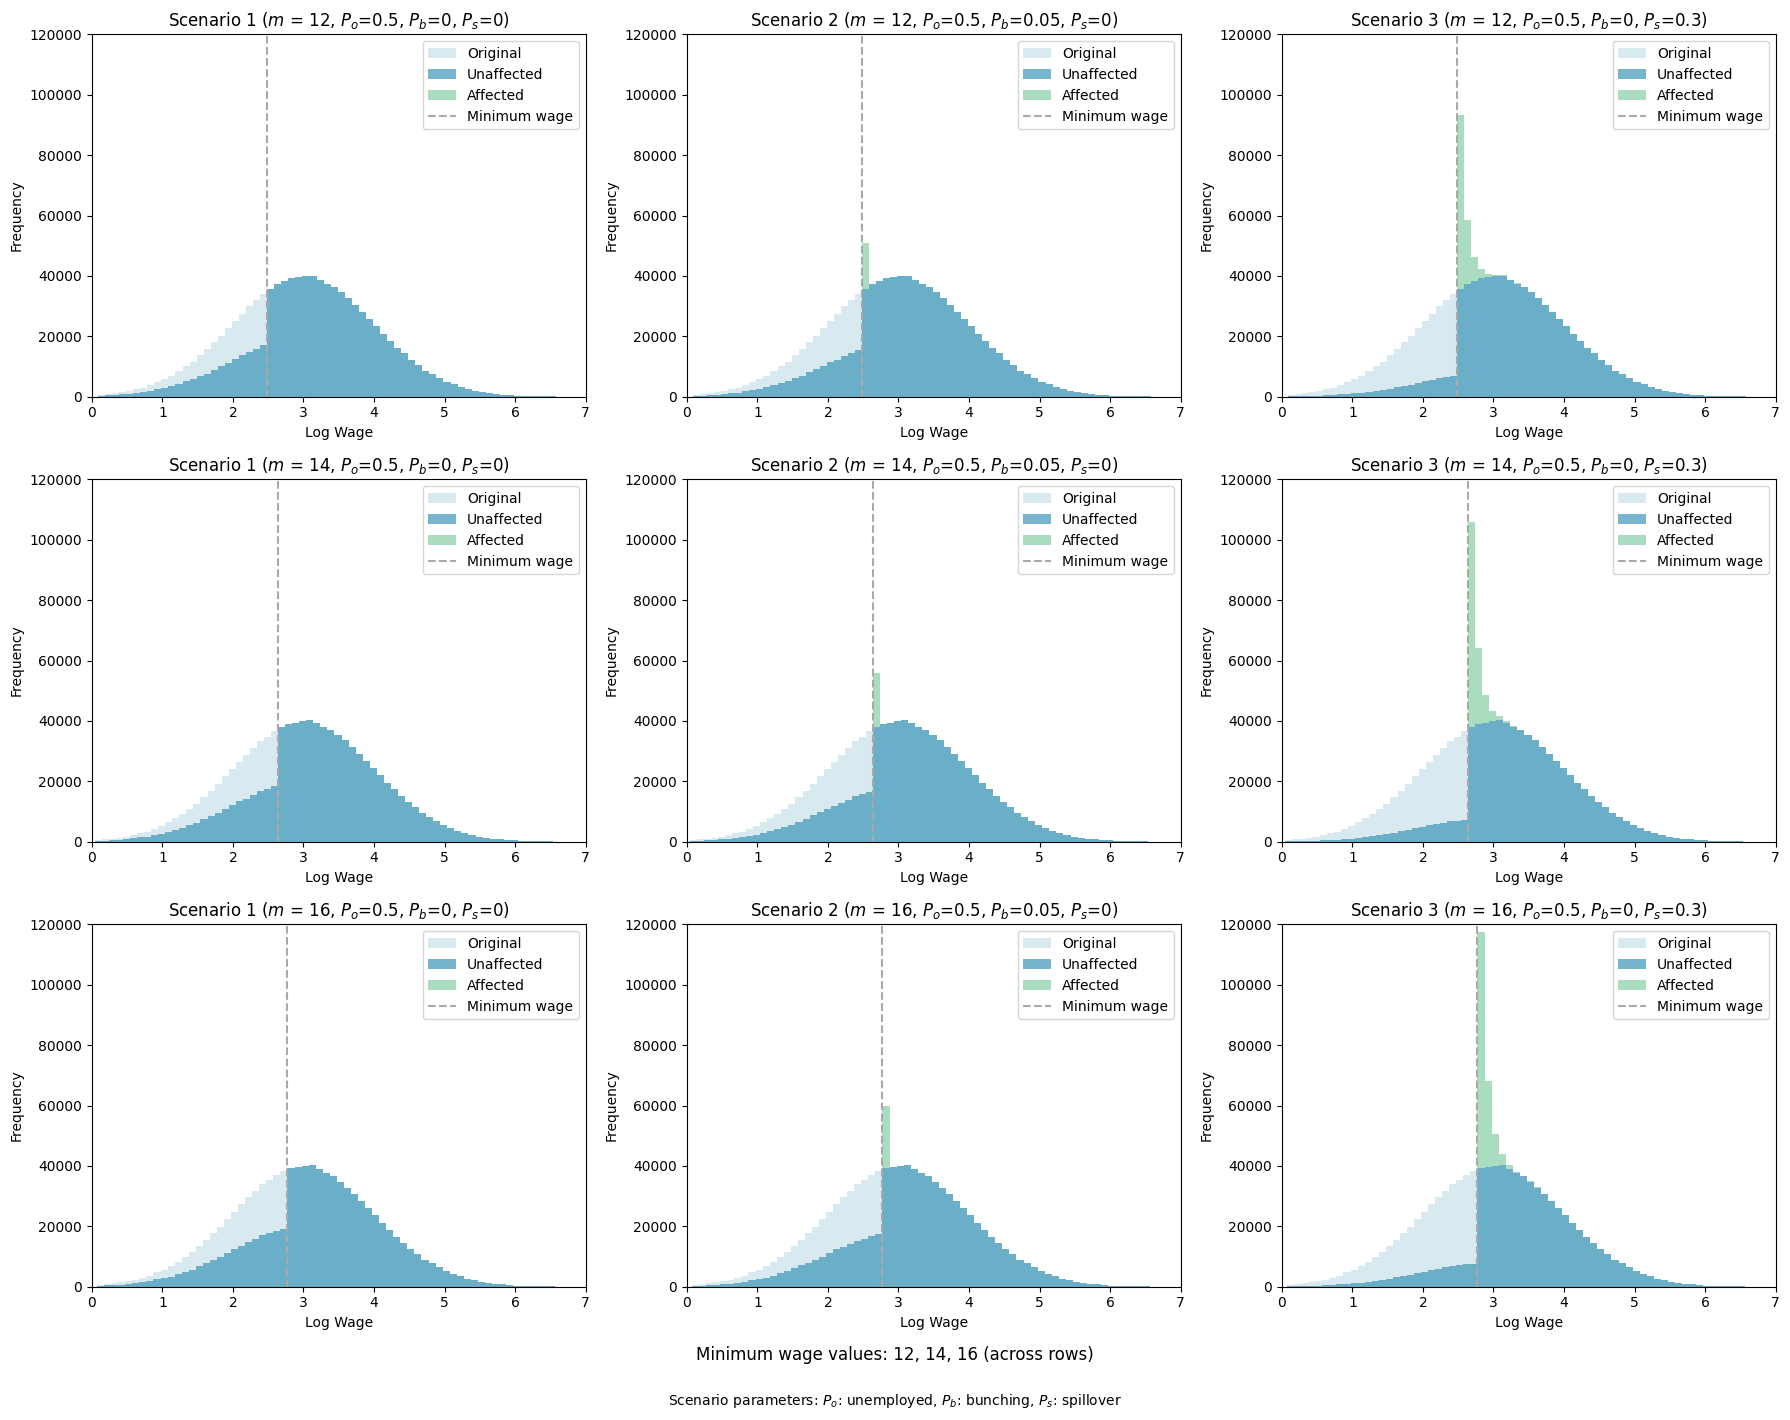

In [3]:
# Define the three minimum wages and scenarios
min_wages = [12, 14, 16]
scenarios = {
    'Scenario 1': (0.5, 0, 0),
    'Scenario 2': (0.5, 0.05, 0),
    'Scenario 3': (0.5, 0, 0.3)
}

# Generate the data and create the figure
fig, axs = plt.subplots(3, 3, figsize=(18, 15))

for i, m in enumerate(min_wages):
    for j, (scenario_name, (P_o, P_b, P_s)) in enumerate(scenarios.items()):
        
        # Apply the impose_minimum_wage function
        df = impose_minimum_wage(log_wages.copy(), m, P_o, P_b, P_s)
        
        # Set up the scenario parameters
        scenario_params = (m, P_o, P_b, P_s)
        
        # Plot the panel
        ax = axs[i, j]
        plot_histogram_panel(ax, df, bins=np.arange(0, 7 + 0.1, 0.1) - 1e-6, 
                             scenario=scenario_name, scenario_params=scenario_params, 
                             max_ylim=120_000, show_unemployed=False, show_percentile=False)

# Add common text
plt.figtext(0.5, 0.04, 'Minimum wage values: 12, 14, 16 (across rows)', ha='center', fontsize=12)
plt.figtext(0.5, 0.01, 'Scenario parameters: $P_o$: unemployed, $P_b$: bunching, $P_s$: spillover', ha='center', fontsize=10)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()


### Naive percentile OLS


In [4]:
# real_m_pre, real_m_post, P_o, P_b, P_s
scenarios = {
    'S1': (12, 14, 0.5, 0, 0),
    'S2': (12, 14, 0.5, 0.05, 0),
    'S3': (12, 14, 0.5, 0, 0.3),
    'S4': (14, 16, 0.5, 0, 0),
    'S5': (14, 16, 0.5, 0.05, 0),
    'S6': (14, 16, 0.5, 0, 0.3)
}

In [21]:
def calculate_percentiles(log_wages, scenario):
    real_m_pre, real_m_post, P_o, P_b, P_s = scenario
    df_pre = impose_minimum_wage(log_wages.copy(), real_m_pre, P_o, P_b, P_s)
    df_post = impose_minimum_wage(log_wages.copy(), real_m_post, P_o, P_b, P_s)
    
    df_pre['real_wages'] = np.exp(df_pre['adjusted_log_wages'])
    df_post['real_wages'] = np.exp(df_post['adjusted_log_wages'])

    percentiles = np.arange(0, 85, 5)

    pre_percentiles = np.percentile(df_pre['real_wages'].dropna(), percentiles)
    post_percentiles = np.percentile(df_post['real_wages'].dropna(), percentiles)
    
    # Calculate 95th percentile
    p95_pre = np.percentile(df_pre['real_wages'].dropna(), 95)
    p95_post = np.percentile(df_post['real_wages'].dropna(), 95)
    x_limit = max(p95_pre, p95_post)

    return pre_percentiles, post_percentiles, df_pre['real_wages'].dropna(), df_post['real_wages'].dropna(), x_limit


The figure shows the relative changes in precentiles as the minimum wage changes. As expected, all percentiles "inflated" as some more people got unemployed. We got bad results as expected.

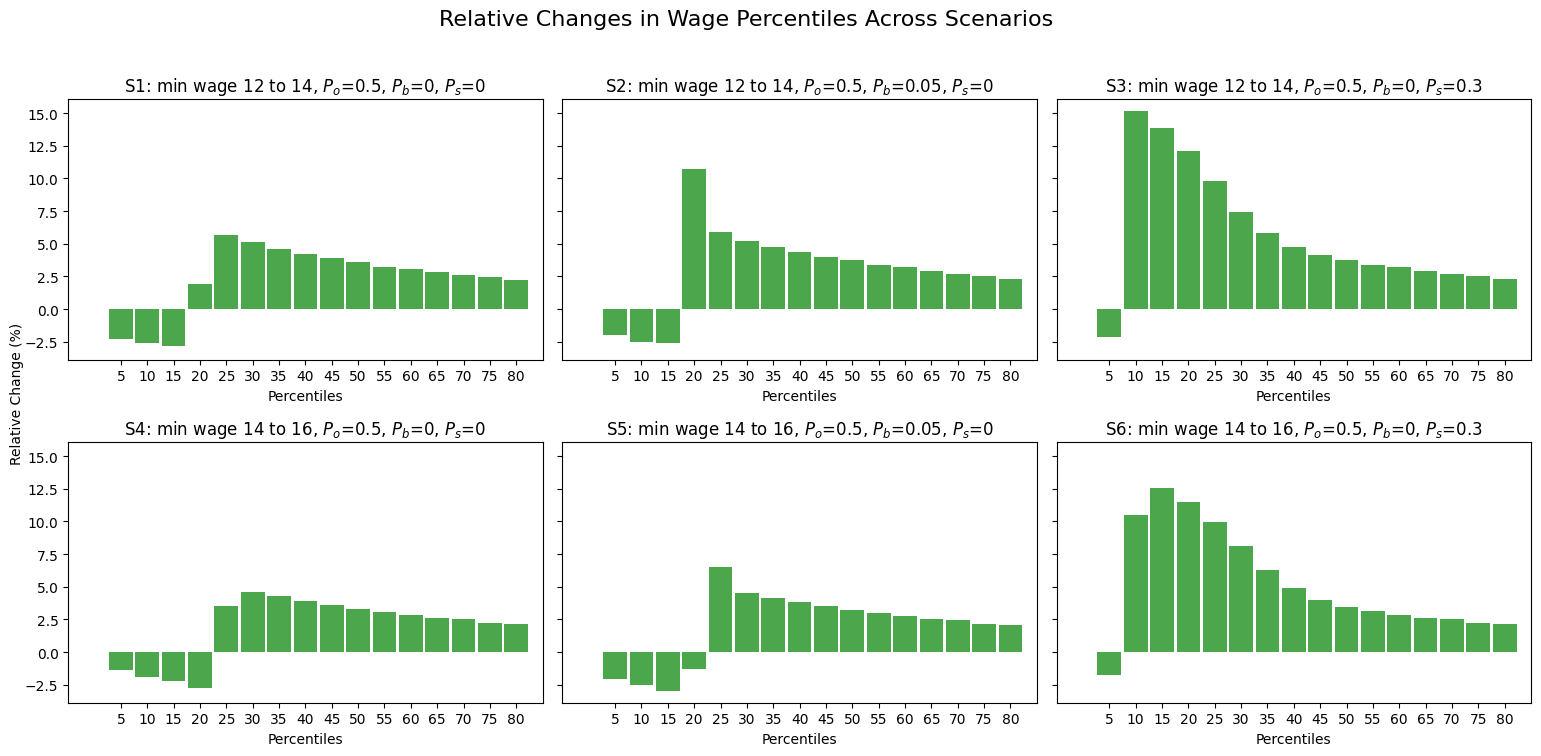

In [22]:
# Define the figure and axes for subplots
fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharey=True)

# Flatten axes for easy iteration
axes = axes.flatten()

# Generate and plot results for each scenario
for i, (scenario_name, params) in enumerate(scenarios.items()):
    pre_percentiles, post_percentiles, _, _, x_limit = calculate_percentiles(log_wages, params)
    relative_changes = (post_percentiles - pre_percentiles) / pre_percentiles * 100

    ax = axes[i]
    percentiles = np.arange(5, 85, 5)

    ax.bar(percentiles, relative_changes[1:], width=4.5, alpha=0.7, color='green')
    ax.set_xlabel('Percentiles')
    # ax.set_ylabel('Relative Change (%)')
    ax.set_title(f'{scenario_name}: min wage {params[0]} to {params[1]}, $P_o$={params[2]}, $P_b$={params[3]}, $P_s$={params[4]}')
    ax.set_xticks(percentiles)
    ax.set_xlim([-5, 85])
    # ax.set_ylim([min(relative_changes[1:]) - 5, max(relative_changes[1:]) + 5])

    # removes outputs pre_percentiles, post_percentiles before next loops:
    del pre_percentiles, post_percentiles, x_limit

# Set the main title
plt.suptitle('Relative Changes in Wage Percentiles Across Scenarios', fontsize=16)
fig.text(0.04, 0.5, 'Relative Change (%)', va='center', rotation='vertical')

# Adjust layout
plt.tight_layout(rect=[0.04, 0.04, 1, 0.96])
plt.show()


#### S1 and S4 only

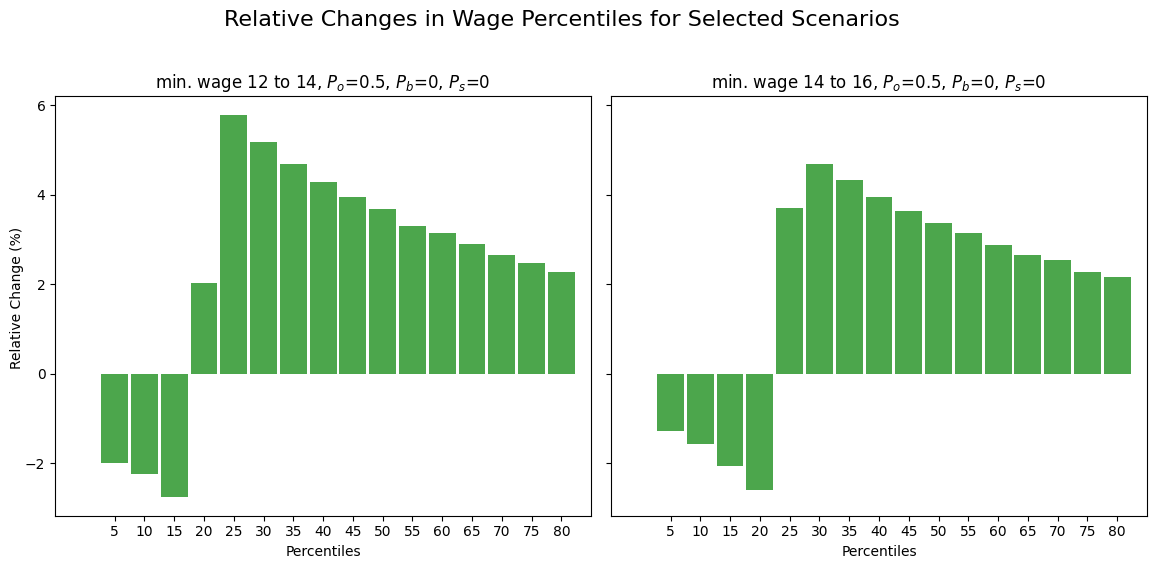

In [23]:
# Define the figure and axes for the two panels
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Scenarios to plot
selected_scenarios = {'S1': scenarios['S1'], 'S4': scenarios['S4']}

# List to store data for exporting
export_data = []

# Plot for each selected scenario
for i, (scenario_name, params) in enumerate(selected_scenarios.items()):
    pre_percentiles, post_percentiles, _, _, x_limit = calculate_percentiles(log_wages, params)
    relative_changes = (post_percentiles - pre_percentiles) / pre_percentiles * 100

    ax = axes[i]
    percentiles = np.arange(5, 85, 5)

    ax.bar(percentiles, relative_changes[1:], width=4.5, alpha=0.7, color='green')
    ax.set_xlabel('Percentiles')
    ax.set_title(f'min. wage {params[0]} to {params[1]}, $P_o$={params[2]}, $P_b$={params[3]}, $P_s$={params[4]}')
    ax.set_xticks(percentiles)
    ax.set_xlim([-5, 85])

    # Collect data for exporting
    for j, percentile in enumerate(percentiles):
        export_data.append({
            'Scenario': scenario_name,
            'Percentile': percentile,
            'Relative Change (%)': relative_changes[j+1]
        })

# Set the main title
plt.suptitle('Relative Changes in Wage Percentiles for Selected Scenarios', fontsize=16)
fig.text(0.04, 0.5, 'Relative Change (%)', va='center', rotation='vertical')

# Adjust layout
plt.tight_layout(rect=[0.04, 0.04, 1, 0.96])
plt.show()

# Export the data to a CSV file
export_df = pd.DataFrame(export_data)
export_df.to_csv('data/S1_S4_scenarios_data.csv', index=False)

#### Wage distribution of S1 and S4


The below figure shows the wage distribution (density) in S1 and S4. In these scenarios, density below the minimum wage are cut half.

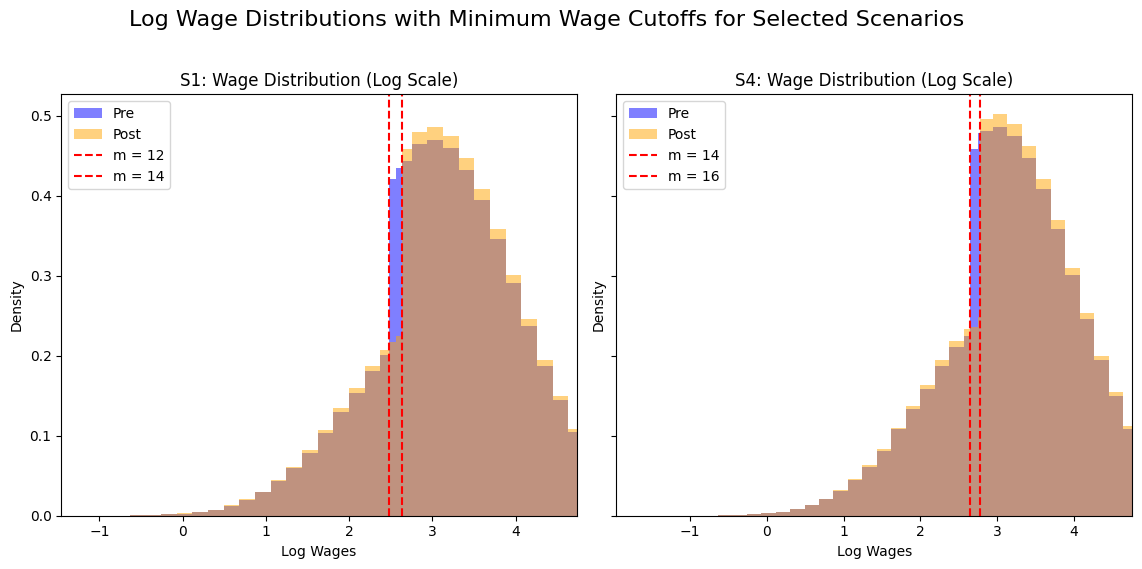

In [24]:
# Define the figure and axes for the two panels
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Scenarios to plot
selected_scenarios = {'S1': scenarios['S1'], 'S4': scenarios['S4']}

# Plot for each selected scenario
for i, (scenario_name, params) in enumerate(selected_scenarios.items()):
    pre_percentiles, post_percentiles, df_pre, df_post, x_limit = calculate_percentiles(log_wages, params)

    ax = axes[i]
    
    # Determine the bin edges, ensuring the minimum wage values are included
    min_wage_bins = np.log([params[0], params[1]])
    all_wages = np.concatenate((np.log(df_pre), np.log(df_post)))
    bins = np.histogram_bin_edges(all_wages, bins=50)
    
    # Add minimum wage cutoffs to bins
    bins = np.unique(np.concatenate((bins, min_wage_bins)))
    
    # Plot histograms for pre and post periods using the same bins
    ax.hist(np.log(df_pre), bins=bins, alpha=0.5, label='Pre', color='blue', density=True)
    ax.hist(np.log(df_post), bins=bins, alpha=0.5, label='Post', color='orange', density=True)
    
    # Add vertical lines for the minimum wage cutoffs
    for wage in [params[0], params[1]]:
        ax.axvline(np.log(wage), color='red', linestyle='--', label=f'm = {wage}')
    
    ax.set_xlabel('Log Wages')
    ax.set_ylabel('Density')
    ax.set_title(f'{scenario_name}: Wage Distribution (Log Scale)')
    ax.legend()

    # Set x-axis limits to the range of log wages
    ax.set_xlim([np.log(df_pre.min()), np.log(x_limit)])

# Set the main title
plt.suptitle('Log Wage Distributions with Minimum Wage Cutoffs for Selected Scenarios', fontsize=16)
plt.tight_layout(rect=[0.04, 0.04, 1, 0.96])
plt.show()


It's easier to see the relative changes of percentile from ecdf. For any given percentile below the minimum wage quantile, "post" period has a lower value, which matches the negative changes we see in the first figure in this subsection; similarly, for any given percentile above the new minimum wage quantile, "post" period has a higher value.

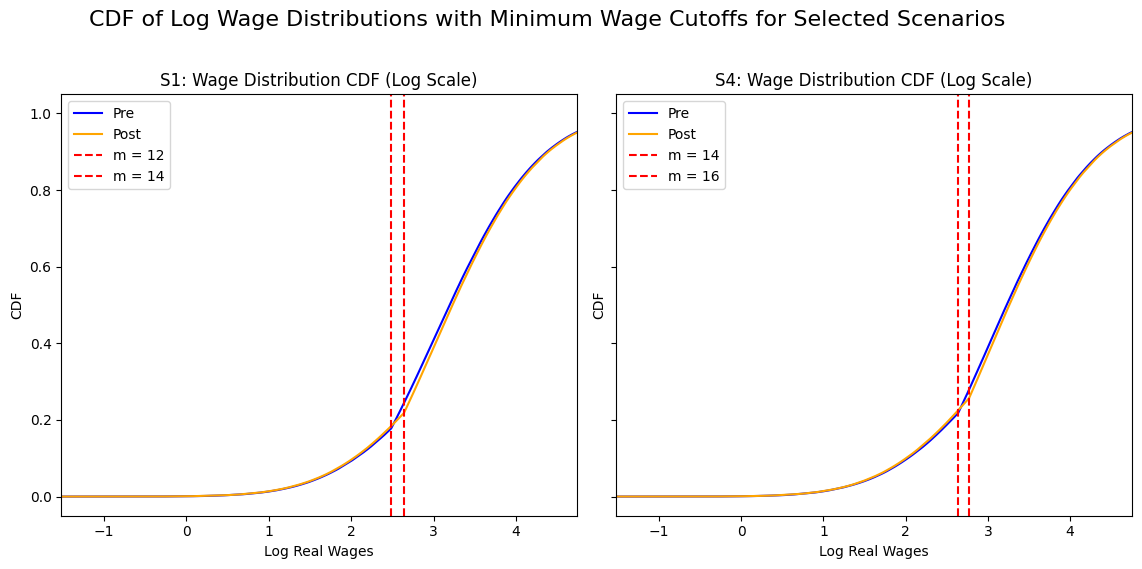

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Define the figure and axes for the two panels
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Scenarios to plot
selected_scenarios = {'S1': scenarios['S1'], 'S4': scenarios['S4']}

# Plot for each selected scenario
for i, (scenario_name, params) in enumerate(selected_scenarios.items()):
    pre_percentiles, post_percentiles, df_pre, df_post, x_limit = calculate_percentiles(log_wages, params)

    ax = axes[i]
    
    # Calculate CDF for pre and post periods
    pre_sorted = np.sort(np.log(df_pre))
    post_sorted = np.sort(np.log(df_post))
    
    pre_cdf = np.arange(1, len(pre_sorted)+1) / len(pre_sorted)
    post_cdf = np.arange(1, len(post_sorted)+1) / len(post_sorted)
    
    # Plot CDFs for pre and post periods
    ax.plot(pre_sorted, pre_cdf, label='Pre', color='blue')
    ax.plot(post_sorted, post_cdf, label='Post', color='orange')
    
    # Add vertical lines for the minimum wage cutoffs
    for wage in [params[0], params[1]]:
        ax.axvline(np.log(wage), color='red', linestyle='--', label=f'm = {wage}')
    
    ax.set_xlabel('Log Real Wages')
    ax.set_ylabel('CDF')
    ax.set_title(f'{scenario_name}: Wage Distribution CDF (Log Scale)')
    ax.legend()

    # Set x-axis limits to the range of log wages
    ax.set_xlim([np.log(df_pre.min()), np.log(x_limit)])

# Set the main title
plt.suptitle('CDF of Log Wage Distributions with Minimum Wage Cutoffs for Selected Scenarios', fontsize=16)
plt.tight_layout(rect=[0.04, 0.04, 1, 0.96])
plt.show()


### Cengiz et al.(2019) Method

In this section, I simplify the regression model in Cengiz et al.(2019). I then present the simulation results in two ways. The first is to plot the regression coefficients, and the second is to replicate the main result figure in their paper, which shows the difference in actual and counterfactual employment based on the regression results. The first method should be more comparable to the hazard estimates, although the coefficient can't be related directly.

I simplified the regression model in their paper into the following specification:

$$
\frac{E_{jt}}{N_t} = \beta_0 + \sum_{k=-4}^{17} \alpha_k I_{jt}^{k} + \mu_j + u_{jt}
$$

- Each bin is $0.25.
- $E_{jt}$: the employment at time $t$ in bin $j$.
- $N_t$: the total population at time $t$ (which is fixed in our setting.) 
- $\mu_j$: wage bin fixed effect.
- $I_{jt}^{k}$: Minmum wage dummies that equals 1 if the $jt$ bin-time pair is between $k$ to $k+1$ dollar above the minimum wage. 
    - For example, if the minimum wage is $14, then the indicator $I^{0}$ flags the four bins from [$14, $14.25), ... to [$14.75, $15). 
    - The dummy $I_{jt}^{-4}$ is 1 for all bins below the minimum wage-\$4. 
- $\alpha_k$: coefficient of desired. Effect of being in $\$k$ to $\$k+1$ above minimum wage on employment share.
- $\mu_j$: wage bin fixed effect. Notice that the fixed effect is at the bin level with width $.25.



In [35]:
# low_min and high_min are tuples representing the minimum wage progression over multiple periods
# low_min = (12, 12.6, 13.2, 14.6, 18)
# high_min = (20, 20.6, 21.2, 22.6, 26)

low_min = (12, 14)
high_min = (14, 16)

# Define the scenarios using low_min and high_min
scenarios = {
    'S1': (low_min, 0.5, 0, 0),
    'S2': (low_min, 0.5, 0.05, 0),
    'S3': (low_min, 0.5, 0, 0.3),
    'S4': (high_min, 0.5, 0, 0),
    'S5': (high_min, 0.5, 0.05, 0),
    'S6': (high_min, 0.5, 0, 0.3)
}

In [36]:
def prepare_cengiz_data(log_wages, scenario, spillover="exponential", num_below_dummies=4, num_above_dummies=17, lowest_cover_all=True):
    """
    Prepare the dataset for analysis by applying minimum wage policies to log_wages.
    This function now works with multiple periods (e.g., using low_min or high_min for multiple periods).
    """
    min_wages, P_o, P_b, P_s = scenario
    total_population = log_wages.shape[0]  # Fixed total population

    # Apply the minimum wage policy to all periods in min_wages
    df_list = []
    for period, real_m in enumerate(min_wages):
        df_period = impose_minimum_wage(log_wages.copy(), real_m, P_o, P_b, P_s, spillover=spillover)
        df_period['real_wages'] = np.round(np.exp(df_period['adjusted_log_wages']), 3)
        df_period['period'] = period
        # df_period['time'] = period  # Use `time` to denote the period
        df_list.append(df_period)

    df_combined = pd.concat(df_list)

    # Bins setup: set bin edges to reflect dollar increments of $0.25
    bins = [0] + list(np.round(np.arange(2, 60, 0.25), 2)) + [60, np.inf]

    def create_min_dummies(df, real_m):
        # Create bins and labels
        df['wagcat'] = pd.cut(df['real_wages'], bins=bins, labels=False, duplicates='drop')
        df['wagcat'] = df['wagcat'].astype('Int64')

        # Find the bin number that corresponds to the minimum wage
        m_bin = pd.cut([real_m], bins=bins, labels=False, duplicates='drop')[0]

        # Group the data by wage categories
        df_grouped = df.groupby('wagcat').size().reset_index(name='fweight')
        df_grouped['normalized_emp'] = df_grouped['fweight'] / total_population  # Calculate E_{jt}/N_t
        max_bin = df_grouped['wagcat'].max()

        # Ensure all bins are included even if some are empty
        all_bins = pd.DataFrame({'wagcat': range(max_bin + 1)})
        df_grouped = pd.merge(all_bins, df_grouped, on='wagcat', how='left').fillna(0)

        # Drop first and max bin
        df_grouped = df_grouped[(df_grouped['wagcat'] != 0) & (df_grouped['wagcat'] != max_bin)]

        # k = 1: 4 bins in a indicator; k = 4: 1 bin in a indicator
        k = 1

        # Calculate the relative dollar distance to the minimum wage
        df_grouped['rel_dollar'] = (df_grouped['wagcat'] - m_bin) * 0.25  # Each bin is $0.25

        # Create dummy variables for bins based on relative dollar distance
        df_grouped['min0'] = ((df_grouped['rel_dollar'] >= 0) & (df_grouped['rel_dollar'] < 1 / k)).astype(int)

        # Create more dummies for the bins below and above the minimum wage
        for i in range(1, num_below_dummies):
            # df_grouped[f'min{i}b'] = ((df_grouped['rel_dollar'] >= -i / k) & 
            df_grouped[f'min{i}b'] = ((df_grouped['rel_dollar'] >= -i / k) & 
                                      (df_grouped['rel_dollar'] < (-i + 1) / k)).astype(int)

        if lowest_cover_all==True:
            df_grouped[f'min{num_below_dummies}b'] = ((df_grouped['rel_dollar'] < (-num_below_dummies+1) / k)).astype(int)
        else:
            df_grouped[f'min{num_below_dummies}b'] = ((df_grouped['rel_dollar'] >= -num_below_dummies / k) & 
                                                      (df_grouped['rel_dollar'] < (-num_below_dummies+1) / k)).astype(int)

        for i in range(1, num_above_dummies + 1):
            df_grouped[f'min{i}a'] = ((df_grouped['rel_dollar'] >= i / k) & 
                                      (df_grouped['rel_dollar'] < (i + 1) / k)).astype(int)

        # Create dummies for individual bins (if needed for the regression)
        bin_dummies = pd.get_dummies(df_grouped['wagcat'], prefix='bin')
        df_grouped = pd.concat([df_grouped, bin_dummies], axis=1)

        return df_grouped

    # Create minimum wage dummies for each period
    df_list_grouped = []
    for period, real_m in enumerate(min_wages):
        df_period = df_combined[df_combined['period'] == period]
        df_grouped_period = create_min_dummies(df_period, real_m)
        df_grouped_period['period'] = period
        # df_grouped_period['time'] = period
        df_list_grouped.append(df_grouped_period)

    # Combine the grouped data for all periods
    df_grouped_combined = pd.concat(df_list_grouped)

    # Ensure boolean columns are appropriately cast to integer
    df_grouped_combined = df_grouped_combined.astype({col: 'int64' if df_grouped_combined[col].dtype == 'bool' else df_grouped_combined[col].dtype for col in df_grouped_combined.columns})

    # Sanity check 1: sum of min* variables should be 0 or 1
    min_vars = [col for col in df_grouped_combined.columns if col.startswith('min')]
    df_grouped_combined['min_sum'] = df_grouped_combined[min_vars].sum(axis=1)
    assert df_grouped_combined['min_sum'].isin([0, 1]).all(), "Sanity check failed: sum of min* variables is not 0 or 1 for some rows."

    # Sanity check 2: sum of bin* variables should be 1
    bin_vars = [col for col in df_grouped_combined.columns if col.startswith('bin')]
    df_grouped_combined['bin_sum'] = df_grouped_combined[bin_vars].sum(axis=1)
    assert (df_grouped_combined['bin_sum'] == 1).all(), "Sanity check failed: sum of bin* variables is not 1 for some rows."

    # Drop auxiliary columns after the sanity checks
    df_grouped_combined = df_grouped_combined.drop(columns=['min_sum', 'bin_sum'])

    # Add a constant term for regression
    df_grouped_combined = sm.add_constant(df_grouped_combined)

    return df_grouped_combined


In [40]:
# Modify your plotting function to return the DataFrame instead of just plotting
def plot_cengiz_fe(log_wages, scenario, scenario_name, **kwargs):
    min_wages, P_o, P_b, P_s = scenario
    data = prepare_cengiz_data(log_wages.copy(), scenario, **kwargs)
    data = data.set_index(['wagcat', 'period'])

    # Prepare the independent variables (min* and bin* dummies)
    X = data.filter(regex='^(min\\d{1,2}|period|wagcat)').copy()
    X = sm.add_constant(X)
    y = data['normalized_emp']

    # Fit the OLS model
    model = PanelOLS(y, X, entity_effects=True, time_effects=False).fit(cov_type='clustered', cluster_entity=True)
    
    # Generate coefficients and standard errors
    paras = model.params.filter(regex='^(min\\d{1,2}|min0)')
    se = model.std_errors.filter(regex='^(min\\d{1,2}|min0)')
    coef_df = pd.DataFrame({'params': paras, 'std_errors': se}).reset_index()

    # for min[n]b, assign rel_pos = -n; for min0, assign rel_pos = 0; for min[n]a, assign rel_pos = n
    coef_df['rel_dollar'] = coef_df['index'].str.extract('(\\d{1,2})').astype(int)
    coef_df['rel_dollar'] = np.where(coef_df['index'].str.contains('a'), coef_df['rel_dollar'], -coef_df['rel_dollar'])
    
    # sort coef_df by rel_pos
    coef_df = coef_df.sort_values('rel_dollar')
    
    # Add scenario name to DataFrame
    coef_df['scenario_name'] = scenario_name
    
    # plot bar plot
    ax.bar(coef_df['rel_dollar'], coef_df['params'], width=1, yerr=coef_df['std_errors'], color='green', alpha=0.7, capsize=3, ecolor='grey', error_kw={'elinewidth': 1, 'capsize': 3})
    ax.set_xlabel('Dollars relative to min. wage')
    ax.set_xticks(np.arange(-4, 18, 1))
    # ax.set_ylim(-0.001, 0.00125)
    ax.set_ylim(-0.005, 0.025)
    ax.set_title(f'{scenario_name}: min. wage set {min_wages}, $P_o$={P_o}, $P_b$={P_b}, $P_s$={P_s}')
    
    return coef_df


Save the regression input data `cengiz_data_all_scenarios.csv`: 

The data contains the input for Cengiz regression. Each row represents a wage bin in a period, and a scenario. You can ignore this file if you’re not going to rerun the regression.

- `scenario`: the name of the scenario
- `scenario_values`: set of minimum wage, $p_o, p_b, p_s$.
    - For example, in S1, `Scenario_values = ((12, 14), 0.5, 0.05, 0)`. This means the data has two periods with minimum wages \$12 and \$14; the model probability $(p_o, p_b, p_s) = (0.5, 0.05, 0)$.
- `period`: the period of data. Two period in the current file.
- `wagcat`: index for wage bin. 
- `bin[n]`: indicator for `wagcat == n`
- `rel_dollar`: relative value in dollars to the minimum wage.
normalized_emp
- `min0`: minimum wage dummy if the bin is \$0 to \$1 relative to the minimum wage. 
- `min[n]a`: \$n above the minimum wage. 
    - For example, if minimum wage is \$14, then `min1a == 1` for bins $[15, 15.25)$ to $[15.75, 16)$. 
    - In this version, the lowest `min4b` is 1 for all wage bins below.


In [41]:
# generate data for all scenarios and save as a csv. add scenario = scenario_name to the dataframe
df_list = []
for scenario_name, scenario in scenarios.items():
    df = prepare_cengiz_data(log_wages.copy(), scenario, num_below_dummies=4, num_above_dummies=17)
    # add scenario_name to the DataFrame
    df['scenario'] = scenario_name
    # add the value of scenario to the DataFrame as a string 
    df['scenario_values'] = str(scenario)    
    
    df_list.append(df)

# Combine all DataFrames into a single DataFrame
df_all = pd.concat(df_list)

# Save the DataFrame to a CSV file
# df_all.to_csv('data/cengiz_data_all_scenarios.csv', index=False)

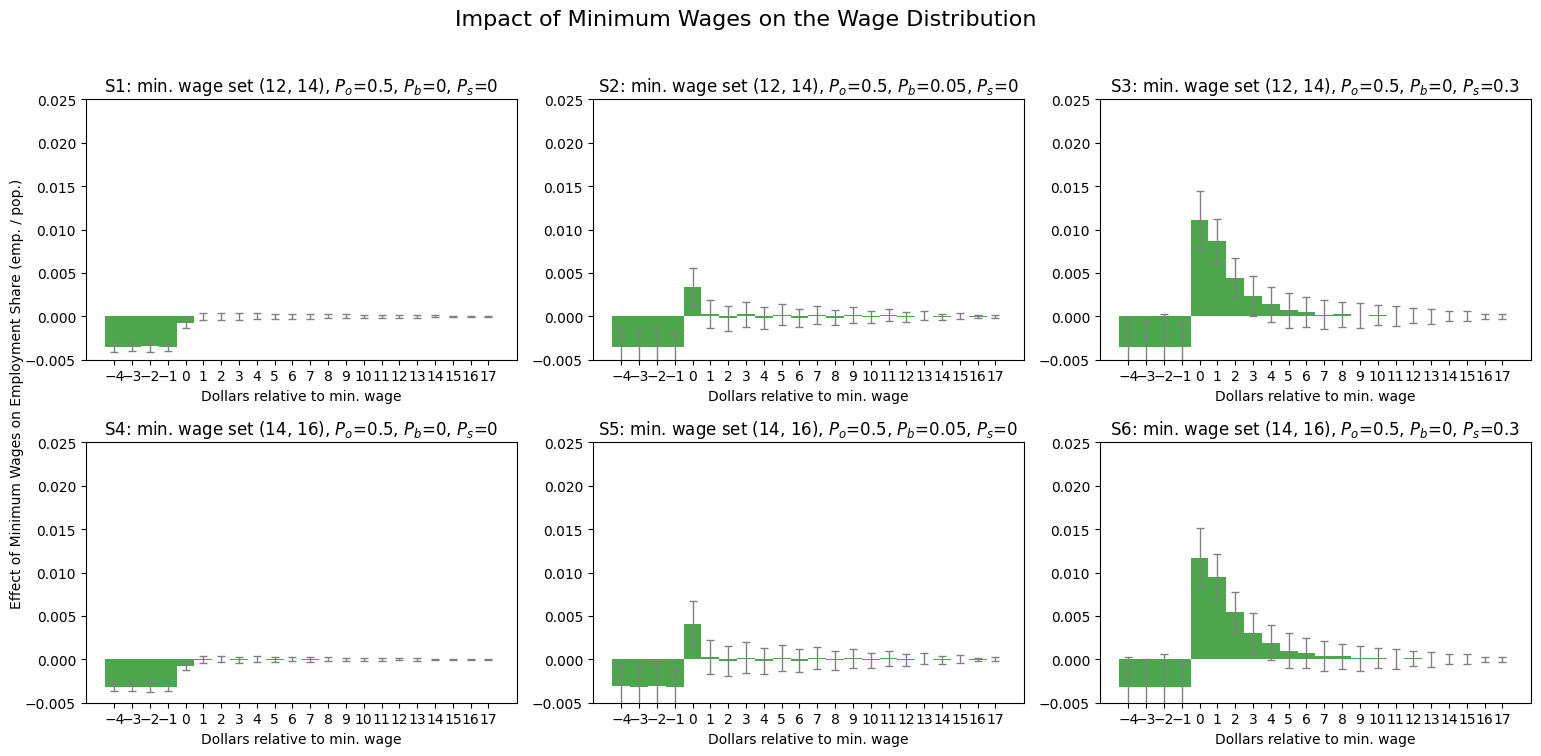

In [42]:
# Initialize an empty DataFrame to store all coefficients
all_coefs_df = pd.DataFrame()

# Create subplots
fig, axs = plt.subplots(2, 3, figsize=(16, 8))

# Generate and plot results for each scenario, and collect the coefficients
for ax, (scenario_name, scenario) in zip(axs.flatten(), scenarios.items()):
    coef_df = plot_cengiz_fe(log_wages, scenario, scenario_name, num_below_dummies=4, num_above_dummies=17, lowest_cover_all=True)
    coef_df['scenario_values'] = str(scenario)

    all_coefs_df = pd.concat([all_coefs_df, coef_df], ignore_index=True)

# Set common ylabel
fig.text(0.04, 0.5, 'Effect of Minimum Wages on Employment Share (emp. / pop.)', va='center', rotation='vertical')
plt.suptitle('Impact of Minimum Wages on the Wage Distribution', fontsize=16)

# Adjust layout 
plt.tight_layout(rect=[0.04, 0.04, 1, 0.96])
plt.show()

# Export the coefficients DataFrame to a CSV file
all_coefs_df.to_csv('data/cengiz_coefficients.csv', index=False)

### Hazard Estimator


I first prepare the data and variables following the definition that Thomas gave me.

In [59]:
def prepare_hazard_var(log_wages, scenario, spillover="exponential", append_unaffected_wages=False, interaction_term=True):
    """
    Prepare hazard variables for multiple periods, applying minimum wage policies across time.
    Input `scenario` includes (min_wages, P_o, P_b, P_s), where min_wages can be for multiple periods.
    """
    min_wages, P_o, P_b, P_s = scenario
    bins = [0] + list(np.arange(3, 4, 0.5)) + list(np.arange(4, 20, 0.1)) + [20, np.inf]
    min_vars = ['min', 'min21b', 'min1620b', 'min1115b','min610b', 'min35b', 'min12b', 'min12a', 'min35a', 'min610a', 'min1115a', 'min1620a']
    
    df_list = []
    
    def create_min_dummies(df, real_m, interaction_term):
        df['wagcat'] = pd.cut(df['real_wages'], bins=bins, labels=False, duplicates='drop')
        df['wagcat'] = df['wagcat'].astype('Int64')

        m_bin = pd.cut([real_m], bins=bins, labels=False, duplicates='drop')[0]

        df_grouped = df.groupby('wagcat').size().reset_index(name='fweight')
        max_bin = df_grouped['wagcat'].max()
        all_bins = pd.DataFrame({'wagcat': range(max_bin + 1)})
        df_grouped = pd.merge(all_bins, df_grouped, on='wagcat', how='left').fillna(0)

        df_grouped['min'] = np.where(df_grouped['wagcat'] == m_bin, 1, 0)
        df_grouped['min21b'] = np.where((df_grouped['wagcat'] <= m_bin - 21), 1, 0)
        df_grouped['min1620b'] = np.where((df_grouped['wagcat'] >= m_bin - 20) & (df_grouped['wagcat'] <= m_bin - 16), 1, 0)
        df_grouped['min1115b'] = np.where((df_grouped['wagcat'] >= m_bin - 15) & (df_grouped['wagcat'] <= m_bin - 11), 1, 0)
        df_grouped['min610b'] = np.where((df_grouped['wagcat'] >= m_bin - 10) & (df_grouped['wagcat'] <= m_bin - 6), 1, 0)
        df_grouped['min35b'] = np.where((df_grouped['wagcat'] >= m_bin - 5) & (df_grouped['wagcat'] <= m_bin - 3), 1, 0)
        df_grouped['min12b'] = np.where((df_grouped['wagcat'] >= m_bin - 2) & (df_grouped['wagcat'] <= m_bin - 1), 1, 0)
        df_grouped['min12a'] = np.where((df_grouped['wagcat'] >= m_bin + 1) & (df_grouped['wagcat'] <= m_bin + 2), 1, 0)
        df_grouped['min35a'] = np.where((df_grouped['wagcat'] >= m_bin + 3) & (df_grouped['wagcat'] <= m_bin + 5), 1, 0)
        df_grouped['min610a'] = np.where((df_grouped['wagcat'] >= m_bin + 6) & (df_grouped['wagcat'] <= m_bin + 10), 1, 0)
        df_grouped['min1115a'] = np.where((df_grouped['wagcat'] >= m_bin + 11) & (df_grouped['wagcat'] <= m_bin + 15), 1, 0)
        df_grouped['min1620a'] = np.where((df_grouped['wagcat'] >= m_bin + 16) & (df_grouped['wagcat'] <= m_bin + 20), 1, 0)
        df_grouped['min_bin'] = m_bin
        df_grouped['rel_min_bin'] = df_grouped['wagcat'] - m_bin

        bin_dummies = pd.get_dummies(df_grouped['wagcat'], prefix='bin')
        df_grouped = pd.concat([df_grouped, bin_dummies], axis=1)

        # Add interaction terms if interaction_term is True
        if interaction_term:
            df_grouped['value_min'] = real_m
            for var in min_vars:
                df_grouped[f'interaction_{var}'] = df_grouped[var] * df_grouped['value_min']
        
        return df_grouped


    for period, real_m in enumerate(min_wages):
        df_period = impose_minimum_wage(log_wages.copy(), real_m, P_o, P_b, P_s, spillover=spillover)
        df_period['real_wages'] = np.exp(df_period['adjusted_log_wages'])
        df_period = df_period.dropna(subset=['real_wages'])
        df_grouped_period = create_min_dummies(df_period, real_m, interaction_term)
        df_grouped_period['period'] = period
        df_list.append(df_grouped_period)

    df_grouped = pd.concat(df_list)

    if append_unaffected_wages:
        df_raw = pd.DataFrame()
        df_raw['real_wages'] = np.exp(log_wages)
        
        df_raw['wagcat'] = pd.cut(df_raw['real_wages'], bins=bins, labels=False, duplicates='drop')
        df_raw['wagcat'] = df_raw['wagcat'].astype('Int64')
        
        df_grouped_raw = df_raw.groupby('wagcat').size().reset_index(name='fweight')
        df_grouped_raw[min_vars] = 0

        bin_dummies = pd.get_dummies(df_grouped_raw['wagcat'], prefix='bin')
        df_grouped_raw = pd.concat([df_grouped_raw, bin_dummies], axis=1)
        df_grouped_raw['period'] = 'counterfactual'
        df_grouped = pd.concat([df_grouped, df_grouped_raw])

    max_bin = df_grouped['wagcat'].max()

    df_grouped = df_grouped.sort_values(by=['period', 'wagcat'], ascending=[True, False])
    df_grouped['remain'] = df_grouped.groupby('period')['fweight'].cumsum()
    df_grouped['hazard'] = df_grouped['fweight'] / df_grouped['remain']

    df_grouped = df_grouped.sort_values(by=['period', 'wagcat'])

    df_grouped['remain_diff'] = df_grouped.groupby('period')['remain'].diff()
    df_grouped['lag_fweight'] = df_grouped.groupby('period')['fweight'].shift(1)

    assert (df_grouped[(df_grouped['lag_fweight'] + df_grouped['remain_diff'] == 0) | df_grouped['remain_diff'].isna()].shape[0] == df_grouped.shape[0]), "Sanity check failed: remain - remain.shift(1) != fweight for some rows"
    assert (df_grouped['fweight'] > 0).all(), "Sanity check failed: fweight <= 0 for some rows"

    df_grouped['cloglog_hazard'] = np.log(-np.log(1 - df_grouped['fweight'] / df_grouped['remain']))

    assert df_grouped[df_grouped['wagcat'] != max_bin]['cloglog_hazard'].notna().all(), "Sanity check failed: cloglog_hazard is NaN for some rows where wagcat != 161"
    df_grouped = df_grouped[df_grouped['wagcat'] != max_bin]

    df_grouped['min_sum'] = df_grouped[min_vars].sum(axis=1)
    assert df_grouped['min_sum'].isin([0, 1]).all(), "Sanity check failed: sum of min* variables is not 0 or 1 for some rows."

    bin_vars = [col for col in df_grouped.columns if col.startswith('bin')]
    df_grouped['bin_sum'] = df_grouped[bin_vars].sum(axis=1)
    assert (df_grouped['bin_sum'] == 1).all(), "Sanity check failed: sum of bin* variables is not 1 for some rows."

    df_grouped = df_grouped.drop(columns=['bin_sum', 'lag_fweight', 'remain_diff'])
    
    return df_grouped



Create data for four scenarios.

In [60]:
# df_appended = pd.DataFrame()

# loop through the scenarios
for scenario_name, scenario in scenarios.items():
    df_grouped = prepare_hazard_var(log_wages, scenario)
    df_grouped['Scenario'] = scenario_name
    # df_appended = pd.concat([df_appended, df_grouped])
    print(f"Scenario: {scenario_name}")
    # print #rows fweight ==0
    # print(df_grouped[df_grouped['fweight']==0].shape[0])
    df_grouped.to_stata(f'data/df_grouped_{scenario_name}.dta')

Scenario: S1
Scenario: S2
Scenario: S3
Scenario: S4
Scenario: S5
Scenario: S6


In [69]:
# %pip install stata_setup
import stata_setup
stata_setup.config("/Applications/Stata/", "se")

In [76]:
%%stata
# execute the following do.file
do "codes/hazard simulation.do" "S1 S2 S3 S4 S5 S6" "interaction"


. # execute the following do.file
Unknown #command
. do "codes/hazard simulation.do" "S1 S2 S3 S4 S5 S6" "interaction"

. cd "/Users/boyuchen/Documents/UBC/RA/minimum_wage"
/Users/boyuchen/Documents/UBC/RA/minimum_wage

. 
. local scenarios `1'

. local interaction `2'

. 
. 
. * Clear the existing Excel file or create a new one
. local excel_file "tables/hazard_`interaction'_coefficients.xlsx"

. putexcel set "`excel_file'", replace
note: file will be replaced when the first putexcel command is issued.

. 
. foreach s in `scenarios'{
  2. quietly{
  3.         
.         di "Run GLM for scenario `s'"
  4.         use data/df_grouped_`s'.dta, clear
  5.         drop min_bin min_sum
  6.         
.         su wagcat
  7.         local maxbin = `r(max)'
  8.         
.         if "`interaction'" == "baseline" {
  9. 
.                 glm fweight min* bin* if remain>0 & wagcat ~= 0 & wagcat ~=  
> `maxbin', link(cloglog) family(binomial remain) 
 10.                 
.         } 
 11.  

In [77]:
# Define the x-axis ranges for the variables
x_ranges = {
    'min': (0, .1),
    'min610b': (-1.0, -.5),
    'min1115b': (-1.5, -1.0),
    'min1620b': (-2.0, -1.5),
    'min21b': (-2.5, -2.0),
    'min35b': (-.5, -.2),
    'min12b': (-.2, .0),
    'min12a': (.1, .3),
    'min35a': (.3, .6),
    'min610a': (.6, 1.1),
    'min1115a': (1.1, 1.6),
    'min1620a': (1.6, 2.0)
}

In [78]:
# Load the Excel file
file_path = 'tables/hazard_baseline_coefficients.xlsx'

# Function to format the data
def format_data(file_path, scenario):
    df = pd.read_excel(file_path, sheet_name=scenario, header=None)
    variables = df.iloc[1, 1:].values
    coefficients = df.iloc[2, 1:].values
    se = df.iloc[3, 1:].values
    data = pd.DataFrame({
        'Variable': variables,
        'Coefficient': coefficients,
        'SE': se,
        'Scenario': scenario
    })

    # only keep columns where variable start with "min"
    data = data[data['Variable'].str.startswith('min')==True]

    return data

glm_result = pd.concat([format_data(file_path, scenario) for scenario in scenarios.keys() ])
# Filter the data for the variables of interest
glm_result = glm_result[glm_result['Variable'].isin(x_ranges.keys())]


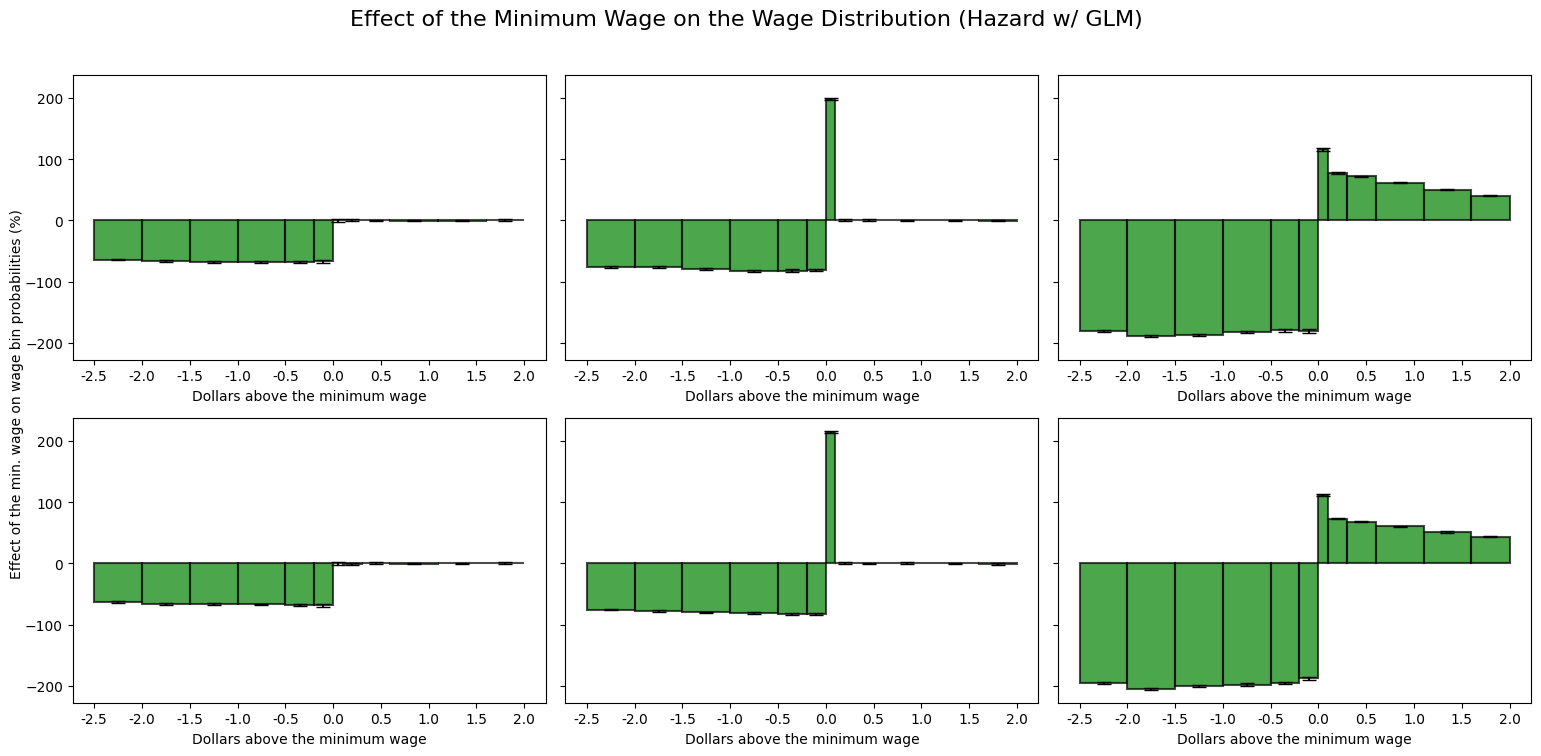

In [79]:
# Define the figure and axes for subplots
fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharey=True)
# Flatten axes for easy iteration
axes = axes.flatten()

# Plot each scenario in a separate subplot
for i, scenario_name in enumerate(scenarios):
    scenario_data_glm = glm_result[glm_result['Scenario'] == scenario_name]

    x_scenario_values_glm = [np.mean([x_ranges[var][0], x_ranges[var][1]]) for var in scenario_data_glm['Variable']]  # Convert to percentage
    y_values_glm = scenario_data_glm['Coefficient'] * 100  # Convert to percentage
    y_err_glm = scenario_data_glm['SE'] * 100  # Convert to percentage
    scenario_widths_glm = [(x_ranges[var][1] - x_ranges[var][0]) for var in scenario_data_glm['Variable']]  # Convert to percentage
        
    # Plot the GLM data with hollow bars 
    axes[i].bar(x_scenario_values_glm, y_values_glm, width=scenario_widths_glm, yerr=y_err_glm, capsize=5, label='GLM', color='green', alpha=0.7, edgecolor='black', linewidth=1.5)
    
    # add old and new minimum wage lines with legend
    # axes[i].axvline(x=real_m_pre - real_m_post, color='blue', linestyle='--', linewidth=2, label='Original minimum wage')
    # axes[i].axvline(x=0, color='red', linestyle='--', linewidth=2, label='New minimum wage')
         
    axes[i].set_xlabel('Dollars above the minimum wage')
    # axes[i].set_title(f'{scenario}: min. wage from {min_wages}, $P_o$={P_o}, $P_b$={P_b}, $P_s$={P_s}')
    
    # Set x-ticks with a break of 5 bins (0.5 dollars)
    axes[i].set_xticks(np.arange(-2.5, 2.1, .5))
    axes[i].set_xticklabels(np.arange(-2.5, 2.1, 0.5))

# Set common ylabel
fig.text(0.04, 0.5, 'Effect of the min. wage on wage bin probabilities (%)', va='center', rotation='vertical')

# Set the main title
plt.suptitle('Effect of the Minimum Wage on the Wage Distribution (Hazard w/ GLM)', fontsize=16)

# Adjust layout
plt.tight_layout(rect=[0.04, 0.04, 1, 0.96])
plt.show()

In [80]:
## this with interaction term
# Load the Excel file
file_path = 'tables/hazard_interaction_coefficients.xlsx'

# Function to format the data
def format_data(file_path, scenario):
    df = pd.read_excel(file_path, sheet_name=scenario, header=None)
    variables = df.iloc[1, 1:].values
    coefficients = df.iloc[2, 1:].values
    se = df.iloc[3, 1:].values
    data = pd.DataFrame({
        'Variable': variables,
        'Coefficient': coefficients,
        'SE': se,
        'Scenario': scenario
    })

    # only keep columns where variable start with "min"
    data = data[data['Variable'].str.startswith('min')==True]

    return data

glm_result = pd.concat([format_data(file_path, scenario) for scenario in scenarios.keys() ])
# Filter the data for the variables of interest
glm_result = glm_result[glm_result['Variable'].isin(x_ranges.keys())]

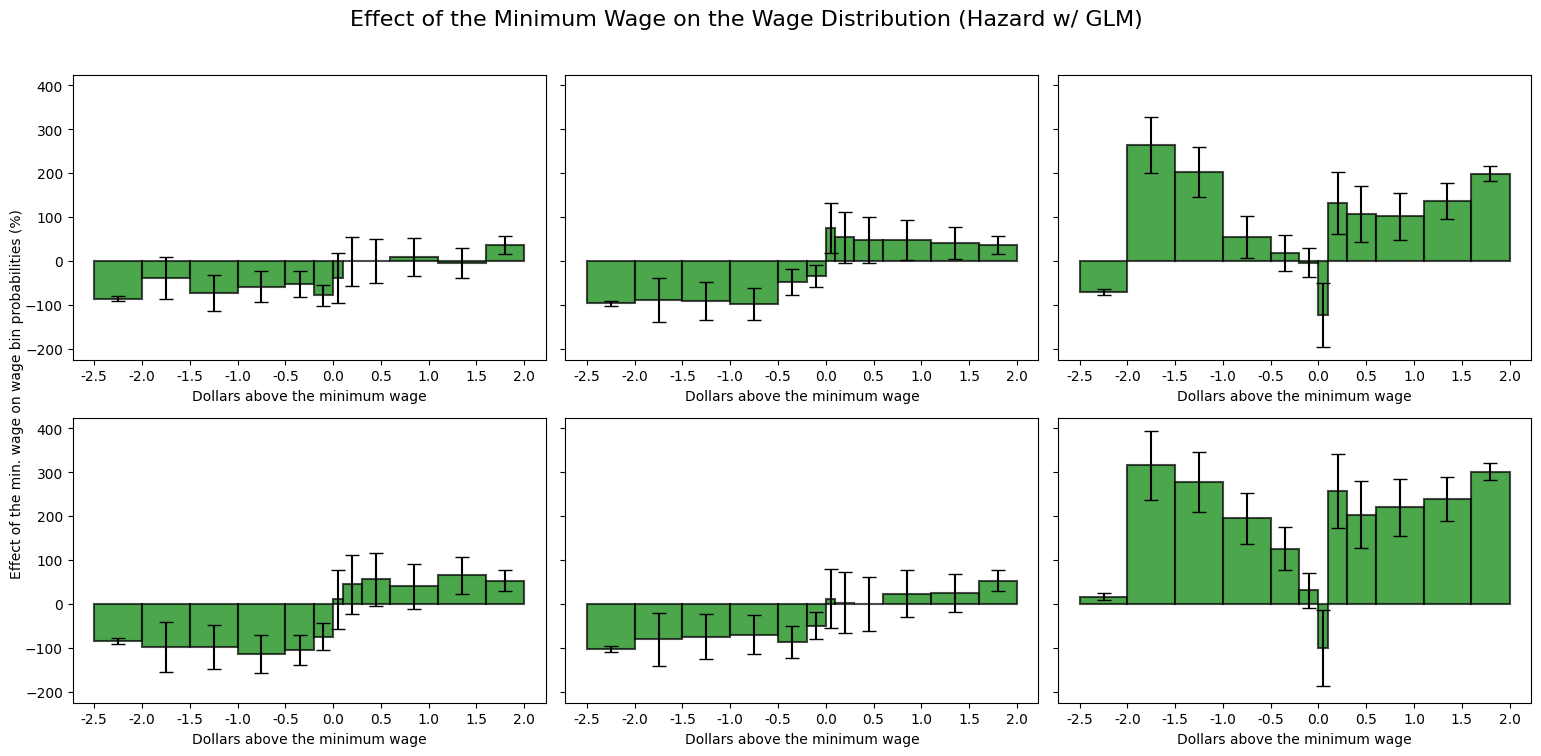

In [81]:
# Define the figure and axes for subplots
fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharey=True)
# Flatten axes for easy iteration
axes = axes.flatten()

# Plot each scenario in a separate subplot
for i, scenario_name in enumerate(scenarios):
    scenario_data_glm = glm_result[glm_result['Scenario'] == scenario_name]

    x_scenario_values_glm = [np.mean([x_ranges[var][0], x_ranges[var][1]]) for var in scenario_data_glm['Variable']]  # Convert to percentage
    y_values_glm = scenario_data_glm['Coefficient'] * 100  # Convert to percentage
    y_err_glm = scenario_data_glm['SE'] * 100  # Convert to percentage
    scenario_widths_glm = [(x_ranges[var][1] - x_ranges[var][0]) for var in scenario_data_glm['Variable']]  # Convert to percentage
        
    # Plot the GLM data with hollow bars 
    axes[i].bar(x_scenario_values_glm, y_values_glm, width=scenario_widths_glm, yerr=y_err_glm, capsize=5, label='GLM', color='green', alpha=0.7, edgecolor='black', linewidth=1.5)
    
    # add old and new minimum wage lines with legend
    # axes[i].axvline(x=real_m_pre - real_m_post, color='blue', linestyle='--', linewidth=2, label='Original minimum wage')
    # axes[i].axvline(x=0, color='red', linestyle='--', linewidth=2, label='New minimum wage')
         
    axes[i].set_xlabel('Dollars above the minimum wage')
    # axes[i].set_title(f'{scenario}: min. wage from {min_wages}, $P_o$={P_o}, $P_b$={P_b}, $P_s$={P_s}')
    
    # Set x-ticks with a break of 5 bins (0.5 dollars)
    axes[i].set_xticks(np.arange(-2.5, 2.1, .5))
    axes[i].set_xticklabels(np.arange(-2.5, 2.1, 0.5))

# Set common ylabel
fig.text(0.04, 0.5, 'Effect of the min. wage on wage bin probabilities (%)', va='center', rotation='vertical')

# Set the main title
plt.suptitle('Effect of the Minimum Wage on the Wage Distribution (Hazard w/ GLM)', fontsize=16)

# Adjust layout
plt.tight_layout(rect=[0.04, 0.04, 1, 0.96])
plt.show()

### Takeaways

- The hazard estimation and Cengiz et al.(2019) both shows the negative employment effect below the minimum wage, and null effect when the model has no bunching or spillover. However, the Cengiz et al.(2019) method largely depends on the numbers of employments in a given bin prior to the minimum wage change. In bins with more counts we will observe a larger negative impact (such as the original minimum wage bin). Such an effect was not observed in the hazard estimation.
- In the hazard estimation, using the GLM and OLS gives the exactly same coefficients. The hazard estimation captures the "drop" for all cells below new minimum wage.
- The naive approach that compares the wage percentile of employed workers captures fallacious spillover effects when there are not (See S1, S2, and S3)

### Interpretation

- Other than the naive approach, the three figures have slightly different interpretations. The first (Cengiz et al. coefficient) shows the effect in employment relative to the total population, so it is unaffected by the employment effect such that many people got unemployeed; the second (Cengiz et al. difference in actual and counterfactual) shows a very similar trend, but it is normalized with the total employment in the previous period, which is also unaffected by the employment effect of the current period. The hazard estimator rules out the employment effect of minimum wage by only consider the relative changes in bins and above (hazard), so any affects on bins below won't create spurious spillover.

## Part II: Comparison between Cengiz and Hazard with different levels of minimum wages.

#### Cengiz and Hazard across minimum wage changes

In this part, we compare the performance of Cengiz and Hazard method with different levels of minimum wages, which also have different density affected by the minimum wages.

In [109]:
# Define Scenarios
A_scenarios = {
    'A1': ((4, 6), 0.5, 0, 0.2),
    'A2': ((8, 10), 0.5, 0, 0.2),
    'A3': ((12, 14), 0.5, 0, 0.2),
    'A4': ((16, 18), 0.5, 0, 0.2)
}


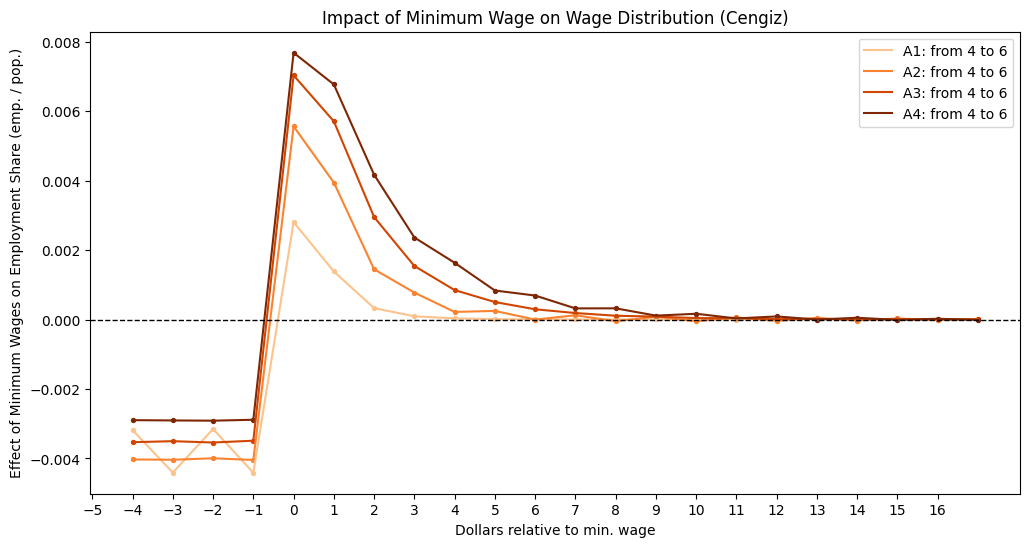

In [114]:
def plot_cengiz_fe_overlay(log_wages, scenarios, spillover = "exponential"):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    cmap = sns.color_palette("Oranges", as_cmap=True)
    # cmap_reversed = cmap.reversed()
    colors = [cmap(i) for i in np.linspace(0.3, 1, len(scenarios))]

    for i, scenario_name in enumerate(scenarios):
        scenario = scenarios[scenario_name]
        min_wages, P_o, P_b, P_s = scenario
        data = prepare_cengiz_data(log_wages, scenario, spillover = spillover)
        data = data.set_index(['wagcat', 'period'])

        # Prepare the independent variables (min* and bin* dummies)
        X = data.filter(regex='^(min\\d{1,2}|time|wagcat)').copy()
        X = sm.add_constant(X)
        y = data['normalized_emp']

        # Fit the OLS model
        model = PanelOLS(y, X, entity_effects=True, time_effects=False).fit(cov_type='clustered', cluster_entity=True)

        # Generate results for each scenario
        coef = model.params.filter(regex='^(min\\d{1,2}|min0)')
        se = model.std_errors.filter(regex='^(min\\d{1,2}|min0)')
        coef_df = pd.DataFrame({'coef': coef, 'std_errors': se}).reset_index()

        # Assign rel_pos for min[n]b, min0, and min[n]a
        coef_df['rel_dollar'] = coef_df['index'].str.extract('(\\d{1,2})').astype(int)
        coef_df['rel_dollar'] = np.where(coef_df['index'].str.contains('a'), coef_df['rel_dollar'], -coef_df['rel_dollar'])
        coef_df = coef_df.sort_values('rel_dollar')

        # Plot line of coefficients for the scenario
        ax.plot(coef_df['rel_dollar'], coef_df['coef'], color=colors[i % len(colors)], label=f'{scenario_name}: from {real_m_pre} to {real_m_post}')
        ax.scatter(coef_df['rel_dollar'], coef_df['coef'], color=colors[i % len(colors)], s=8)

    # Add a horizontal line at 0
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

    ax.set_xlabel('Dollars relative to min. wage')
    ax.set_ylabel('Effect of Minimum Wages on Employment Share (emp. / pop.)')
    ax.set_xticks(np.arange(-5, 17, 1))
    ax.set_title('Impact of Minimum Wage on Wage Distribution (Cengiz)')
    ax.legend()
    plt.show()

# Example call to the function
plot_cengiz_fe_overlay(log_wages, A_scenarios)

In [116]:
# loop through the scenarios
for scenario_name, scenario in A_scenarios.items():
    df_grouped = prepare_hazard_var(log_wages, scenario)
    df_grouped['Scenario'] = scenario_name
    print(f"Scenario: {scenario_name}")
    df_grouped.to_stata(f'data/df_grouped_{scenario_name}.dta')

Scenario: A1
Scenario: A2
Scenario: A3
Scenario: A4


In [117]:
# %pip install stata_setup
import stata_setup
stata_setup.config("/Applications/Stata/", "se")

In [118]:
%%stata
# execute the following do.file
do "codes/hazard simulation.do" "A1 A2 A3 A4" "baseline"

In [119]:
# Load the Excel file
file_path = 'tables/hazard_baseline_coefficients.xlsx'

# Function to format the data
def format_data(file_path, scenario):
    df = pd.read_excel(file_path, sheet_name=scenario, header=None)
    variables = df.iloc[1, 1:].values
    coefficients = df.iloc[2, 1:].values
    se = df.iloc[3, 1:].values
    data = pd.DataFrame({
        'Variable': variables,
        'Coefficient': coefficients,
        'SE': se,
        'Scenario': scenario
    })

    # only keep columns where variable start with "min"
    data = data[data['Variable'].str.startswith('min')==True]

    return data

glm_result = pd.concat([format_data(file_path, scenario) for scenario in A_scenarios.keys() ])
# Filter the data for the variables of interest
glm_result = glm_result[glm_result['Variable'].isin(x_ranges.keys())]

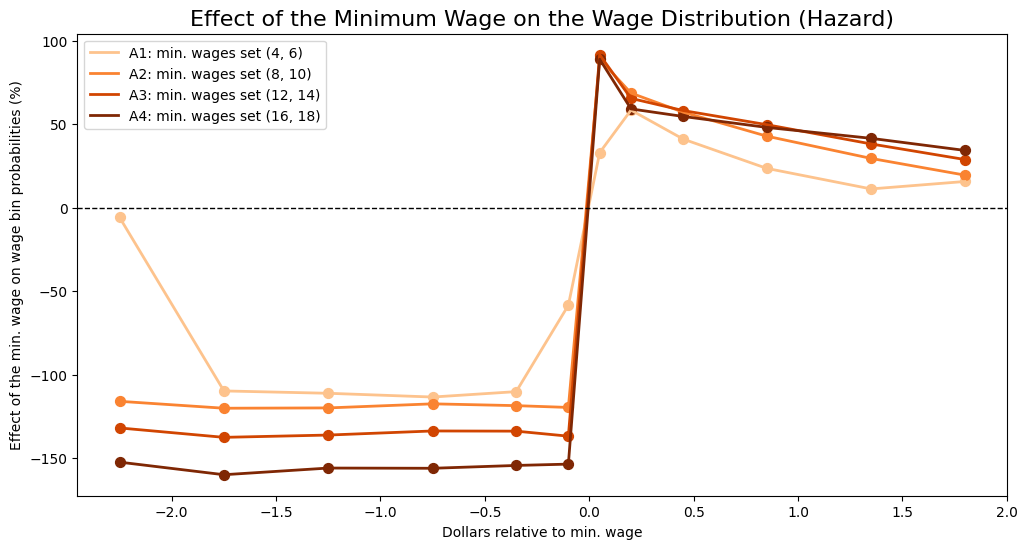

In [120]:
def plot_hazard_overlay(glm_result, scenarios, spillover = "exponential"):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Define the colormap and select colors starting from a darker shade
    cmap = sns.color_palette("Oranges", as_cmap=True)
    colors = [cmap(i) for i in np.linspace(0.3, 1, len(scenarios))]

    for i, scenario_name in enumerate(scenarios):
        scenario = scenarios[scenario_name]
        min_wages, P_o, P_b, P_s = scenario
        scenario_data_glm = glm_result[glm_result['Scenario'] == scenario_name]
        
        # Calculate the x and y values for plotting
        x_scenario_values_glm = [np.mean([x_ranges[var][0], x_ranges[var][1]]) for var in scenario_data_glm['Variable']]
        y_values_glm = scenario_data_glm['Coefficient'] * 100  # Convert to percentage

        # Sort the x and y values for proper line plotting
        sorted_indices = np.argsort(x_scenario_values_glm)
        x_scenario_values_glm = np.array(x_scenario_values_glm)[sorted_indices]
        y_values_glm = np.array(y_values_glm)[sorted_indices]

        # Plot the line of coefficients
        ax.plot(x_scenario_values_glm, y_values_glm, color=colors[i % len(colors)], 
                label=f'{scenario_name}: min. wages set {min_wages}', linewidth=2)
        
        # Optional: You can keep the scatter points to emphasize the positions
        ax.scatter(x_scenario_values_glm, y_values_glm, color=colors[i % len(colors)], s=50)

    # Add a horizontal line at y=0
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

    # Set axis labels and title
    ax.set_xlabel('Dollars relative to min. wage')
    ax.set_ylabel('Effect of the min. wage on wage bin probabilities (%)')
    ax.set_xticks(np.arange(-2, 2.1, 0.5))
    ax.set_title('Effect of the Minimum Wage on the Wage Distribution (Hazard)', fontsize=16)

    # Create the legend
    ax.legend()

    plt.show()

# Example call to the function
plot_hazard_overlay(glm_result, A_scenarios)

#### Effect on Density

To better compare the two methods, we transformed the estimates into the effect of minimum wage on density. 

In [121]:
scenarios = {
    'A1': ((4, 6), 0.5, 0, 0.2),
    'A2': ((8, 10), 0.5, 0, 0.2),
    'A3': ((12, 14), 0.5, 0, 0.2),
    'A4': ((16, 18), 0.5, 0, 0.2)
}

##### Cengiz et al

Recall the Cengiz et al method reports the effect of minimum wage on employment share (share of employment in each wage bin over total population count.) Step-by-step of how I arrive to the effect on density:

1. Estimate the Cengiz coefficient.
2. The Cengiz coefficients are the effect of minimum wage changes on share of employments in wage bins over the total population, so rescaling it by the total population over total employments will give us the density.
    - This is not density per say, because the total employments in the two periods are not the same.

In [127]:
def plot_cengiz_density(log_wages, scenario, scenario_name, num_below_dummies=4, num_above_dummies=17):
    # min_wages, P_o, P_b, P_s = scenario
    
    # Prepare data and get total population
    data = prepare_cengiz_data(log_wages.copy(), scenario, num_below_dummies=num_below_dummies, num_above_dummies=num_above_dummies)

    # Get total employment for pre and post periods
    total_population = log_wages.shape[0]
    total_employment_pre = data[data['period'] == 0]['normalized_emp'].sum() * total_population
    total_employment_post = data[data['period'] == 1]['normalized_emp'].sum() * total_population
    
    data = data.set_index(['wagcat', 'period'])

    # Prepare the independent variables (min* and bin* dummies)
    X = data.filter(regex='^(min\\d{1,2})').copy()
    X = sm.add_constant(X)
    y = data['normalized_emp']

    # Fit the OLS model
    model = PanelOLS(y, X, entity_effects=True, time_effects=False).fit(cov_type='clustered', cluster_entity=True)
    
    # Generate coefficients and standard errors
    coef = model.params.filter(regex='^(min\\d{1,2}|min0)')
    se = model.std_errors.filter(regex='^(min\\d{1,2}|min0)')
    coef_df = pd.DataFrame({'coef': coef, 'std_errors': se}).reset_index()

    # Multiply coefficients by the ratio of total population to total employment
    coef_df['coef_pre_density'] = coef_df['coef'] * (total_population / total_employment_pre)
    coef_df['coef_post_density'] = coef_df['coef'] * (total_population / total_employment_post)

    # For min[n]b, assign rel_pos = -n; for min0, assign rel_pos = 0; for min[n]a, assign rel_pos = n
    coef_df['rel_dollar'] = coef_df['index'].str.extract('(\\d{1,2})').astype(int)
    coef_df['rel_pos'] = np.where(coef_df['index'].str.contains('a'), coef_df['rel_pos'], -coef_df['rel_pos'])
    coef_df['rel_dollar'] = coef_df['rel_pos'] * 0.1

    # Sort coef_df by rel_pos
    coef_df = coef_df.sort_values('rel_pos')
    
    # Add scenario name to DataFrame
    # coef_df['scenario_name'] = scenario_name
    
    # Plot both pre and post period effects in the same figure using subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), sharey=True)

    # Pre-period plot
    axes[0].bar(coef_df['rel_dollar'], coef_df['coef_pre_density'], width=0.1, yerr=coef_df['std_errors'], color='blue', alpha=0.7, capsize=3, ecolor='grey', error_kw={'elinewidth': 1, 'capsize': 3})
    axes[0].set_xlabel('Dollars relative to min. wage')
    axes[0].set_xticks(np.arange(-2, 2.1, 0.5))
    axes[0].set_title(f'Pre-period effect on density')

    # Post-period plot
    axes[1].bar(coef_df['rel_dollar'], coef_df['coef_post_density'], width=0.1, yerr=coef_df['std_errors'], color='green', alpha=0.7, capsize=3, ecolor='grey', error_kw={'elinewidth': 1, 'capsize': 3})
    axes[1].set_xlabel('Dollars relative to min. wage')
    axes[1].set_xticks(np.arange(-2, 2.1, 0.5))
    axes[1].set_title(f'Post-period effect on density')

    # Set the main title
    fig.suptitle(f'{scenario_name}: Effect on density, min. wage from {real_m_pre} to {real_m_post}, $P_o$={P_o}, $P_b$={P_b}, $P_s$={P_s}', fontsize=16)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
    return coef_df


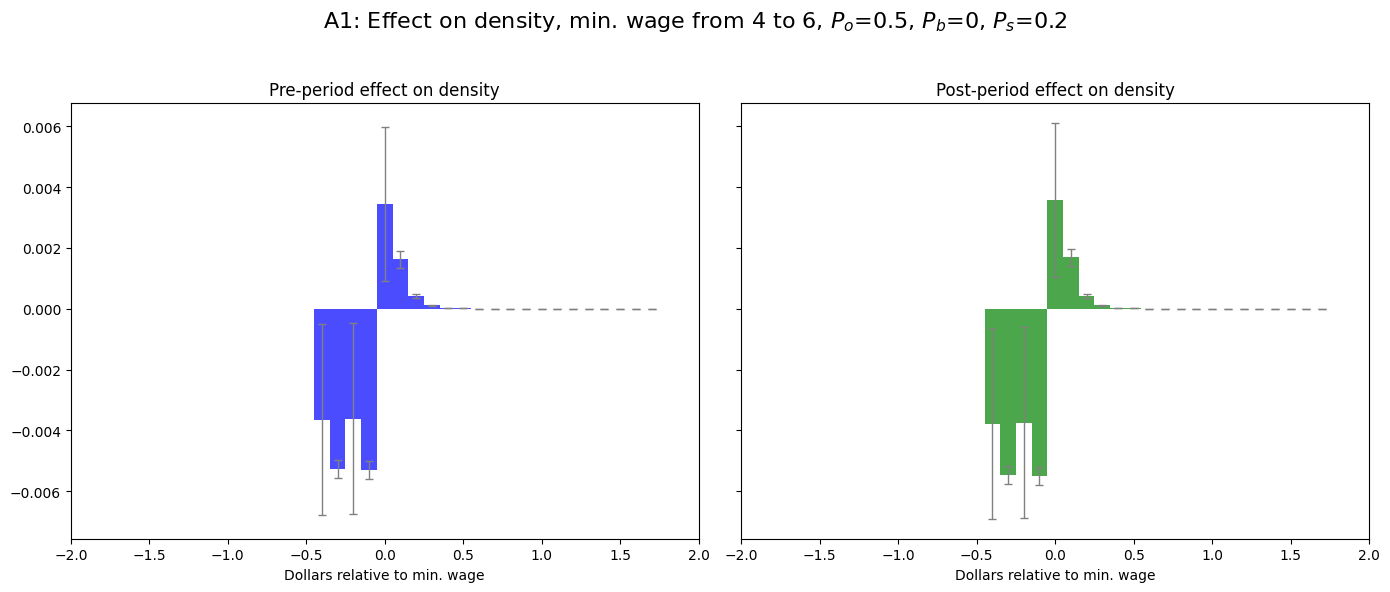

,index,coef,std_errors,coef_pre_density,coef_post_density,rel_pos,rel_dollar
4,min4b,-3.034917e-03,3.131788e-03,-3.642863e-03,-3.777309e-03,-4,-0.4
3,min3b,-4.384250e-03,2.919417e-04,-5.262491e-03,-5.456712e-03,-3,-0.3
2,min2b,-3.011250e-03,3.131753e-03,-3.614456e-03,-3.747853e-03,-2,-0.2
1,min1b,-4.413500e-03,2.906347e-04,-5.297601e-03,-5.493117e-03,-1,-0.1
0,min0,2.869000e-03,2.530455e-03,3.443711e-03,3.570806e-03,0,0.0
5,min1a,1.357250e-03,2.752999e-04,1.629131e-03,1.689256e-03,1,0.1
6,min2a,3.407500e-04,6.228304e-05,4.090081e-04,4.241033e-04,2,0.2
7,min3a,9.100000e-05,1.265794e-05,1.092289e-04,1.132601e-04,3,0.3
8,min4a,2.850000e-05,3.416480e-06,3.420904e-05,3.547159e-05,4,0.4
9,min5a,9.750000e-06,1.616770e-06,1.170309e-05,1.213502e-05,5,0.5


In [128]:
scenario_name = "A1"
scenario = scenarios[scenario_name]

plot_cengiz_density(log_wages, scenario, scenario_name, num_below_dummies=4, num_above_dummies=17)

#### Hazard
In the hazard estimation, the coefficients represent the effect of minimum wage on the hazard probability. Here's the step-by-step of how I generate the results.

1. Estimate the hazard coefficients
2. Predict the fitted hazard and density with the model coefficients. Notice that using `glm` in STATA, we predict `fweight` instead of the hazard. 
3. Calculate the "effect on density" using the fitted fweight.

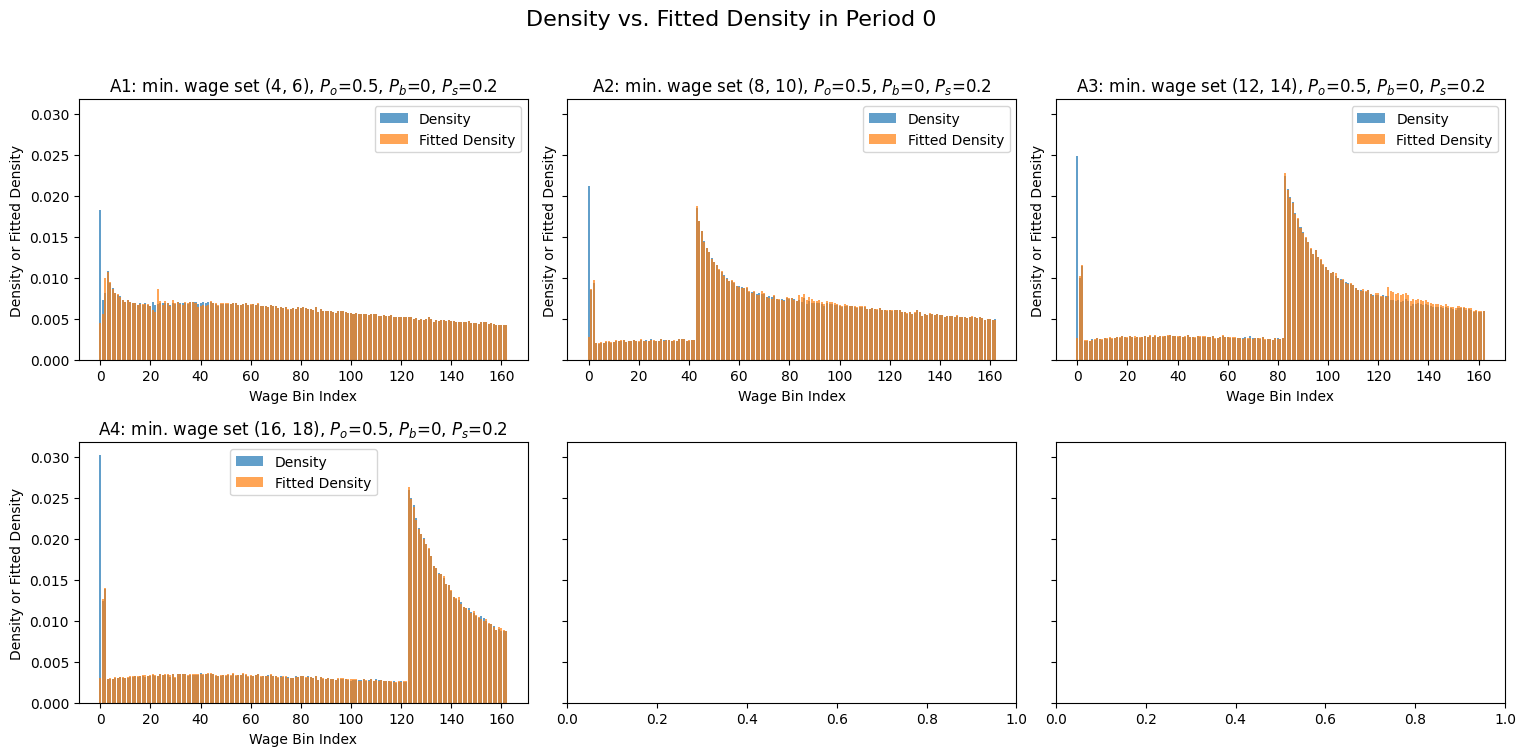

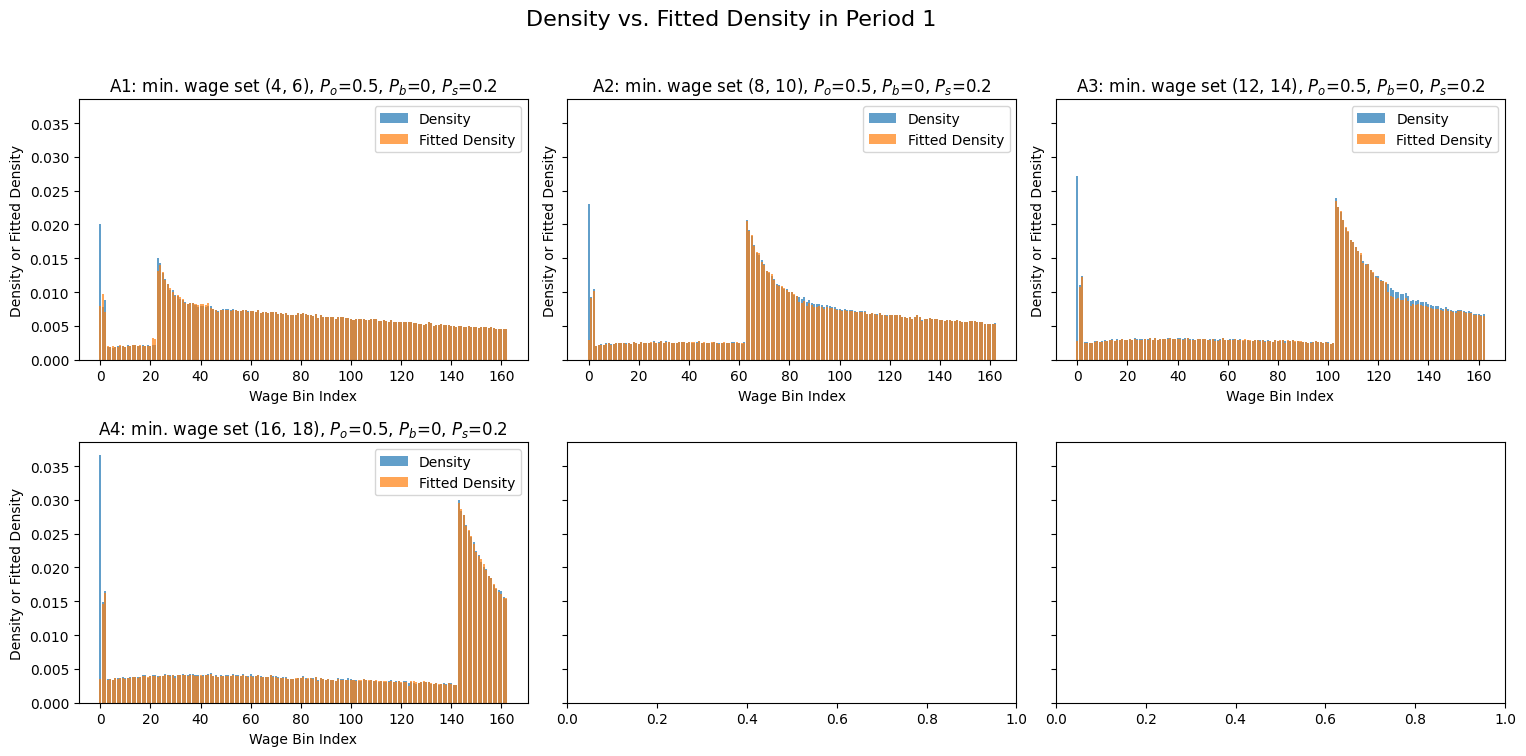

In [124]:
for t in [0, 1]:
    
    # Create a new figure for each period (pre/post)
    fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharey=True)
    axes = axes.flatten()
    
    # Loop through each scenario and plot the histogram
    for i, scenario_name in enumerate(scenarios):
        min_wages, P_o, P_b, P_s = scenarios[scenario_name]

        # Read the dataset for the current scenario
        df = pd.read_stata(f"data/output/hazard_fitted_baseline_{scenario_name}.dta")
        
        # filter period == t
        df = df[df['period'] == t]

        # Calculate the densities
        df['density'] = df['fweight'] / df['fweight'].sum()
        df['fitted_density'] = df['fitted_fweight'] / df['fweight'].sum()  # Use fweight sum for consistency
        
        # Plot the bar plot. x is wagcat and y is density
        axes[i].bar(df['wagcat'], df['density'], label='Density', alpha=0.7)
        axes[i].bar(df['wagcat'], df['fitted_density'], label='Fitted Density', alpha=0.7)

        # Set title and labels
        axes[i].set_title(f'Scenario {scenario}')
        axes[i].set_xlabel('Wage Bin Index')
        axes[i].set_ylabel('Density or Fitted Density')
        axes[i].set_title(f'{scenario_name}: min. wage set {min_wages}, $P_o$={P_o}, $P_b$={P_b}, $P_s$={P_s}')

        # Add legend
        axes[i].legend()

    # Adjust the layout and add the main title: Density vs. Fitted Density in Period {t}
    plt.suptitle(f'Density vs. Fitted Density in Period {t}', fontsize=16)
    plt.tight_layout(rect=[0.04, 0.04, 1, 0.96])
    
    # Show the plot for this period
    plt.show()

    # Close the figure after showing
    plt.close(fig)

In [76]:
scenario = scenarios["S3"]
real_m_pre, real_m_post, P_o, P_b, P_s = scenario

# Prepare data and get total population
data = prepare_cengiz_data(log_wages.copy(), scenario, num_below_dummies=20, num_above_dummies=20)

data = data.set_index(['wagcat', 'time'])

# Get total employment for pre and post periods
total_population = log_wages.shape[0]
total_employment_pre = data[data['period'] == "pre"]['normalized_emp'].sum() * total_population
total_employment_post = data[data['period'] == "post"]['normalized_emp'].sum() * total_population

# Prepare the independent variables (min* and bin* dummies)
X = data.filter(regex='^(min\\d{1,2}|time|wagcat)').copy()
X = sm.add_constant(X)
y = data['normalized_emp']

# Fit the OLS model
model = PanelOLS(y, X, entity_effects=True, time_effects=False).fit(cov_type='clustered', cluster_entity=True)

# Generate fitted values (fitted_normalized_emp) and add them to the data
data['fitted_normalized_emp'] = model.predict(X)

# Rescale fitted_normalized_emp to fitted_density_lag and fitted_density
data['fitted_density_lag'] = data['fitted_normalized_emp'] * (total_population / total_employment_pre)
data['fitted_density'] = data['fitted_normalized_emp'] * (total_population / total_employment_post)

# Pivot the data to get pre and post values for both fitted_density_lag and fitted_density
data_pivot = data.pivot_table(index='wagcat', columns='period', values=['fitted_density_lag', 'fitted_density', 'rel_pos']).reset_index()

# Calculate the effect on density lag and effect on density
data_pivot['effect_on_density_lag'] = (data_pivot[('fitted_density_lag', 'post')] - data_pivot[('fitted_density_lag', 'pre')]) / data_pivot[('fitted_density_lag', 'pre')]
data_pivot['effect_on_density'] = (data_pivot[('fitted_density', 'post')] - data_pivot[('fitted_density', 'pre')]) / data_pivot[('fitted_density', 'pre')]
data_pivot

wagcat fitted_density           fitted_density_lag           rel_pos  \
period                  post       pre               post       pre    post   
0           0       0.003855  0.003855           0.003728  0.003728  -121.0   
1           1       0.003855  0.003855           0.003728  0.003728  -120.0   
2           2       0.003855  0.003855           0.003728  0.003728  -119.0   
3           3       0.003855  0.003855           0.003728  0.003728  -118.0   
4           4       0.003855  0.003855           0.003728  0.003728  -117.0   
..        ...            ...       ...                ...       ...     ...   
237       237       0.003855  0.003855           0.003728  0.003728   116.0   
238       238       0.003855  0.003855           0.003728  0.003728   117.0   
239       239       0.003855  0.003855           0.003728  0.003728   118.0   
240       240       0.003855  0.003855           0.003728  0.003728   119.0   
241       241       0.003855  0.003855           0.003728  0.003728   120.0   

              effect_on_density_lag effect_on_density  
period    pre                                          
0      -101.0                   0.0               0.0  
1      -100.0                   0.0               0.0  
2       -99.0                   0.0               0.0  
3       -98.0                   0.0               0.0  
4       -97.0                   0.0               0.0  
..        ...                   ...               ...  
237     136.0                   0.0               0.0  
238     137.0                   0.0               0.0  
239     138.0                   0.0               0.0  
240     139.0                   0.0               0.0  
241     140.0                   0.0               0.0  

[242 rows x 9 columns]

In [126]:
data = prepare_cengiz_data(log_wages.copy(), scenario, num_below_dummies=4, num_above_dummies=17)

data

,const,wagcat,fweight,normalized_emp,rel_dollar,min0,min1b,min2b,min3b,min4b,...,bin_224,bin_225,bin_226,bin_227,bin_228,bin_229,bin_230,bin_231,bin_232,period
1,1.0,1,1134,0.001134,-1.75,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,2,1300,0.001300,-1.50,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,3,1481,0.001481,-1.25,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,4,1553,0.001553,-1.00,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1.0,5,1735,0.001735,-0.75,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,1.0,228,919,0.000919,53.00,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
229,1.0,229,925,0.000925,53.25,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
230,1.0,230,882,0.000882,53.50,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
231,1.0,231,1004,0.001004,53.75,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [88]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS

def fit_cengiz_density(log_wages, scenario, scenario_name):
    min_wages, P_o, P_b, P_s = scenario
    
    # Prepare data and get total population
    data = prepare_cengiz_data(log_wages.copy(), scenario, num_below_dummies=4, num_above_dummies=17)
    data = data.set_index(['wagcat', 'period'])

    # Get total population
    total_population = log_wages.shape[0]

    # Prepare the independent variables (min* and bin* dummies)
    X = data.filter(regex='^(min\\d{1,2}|time|wagcat)').copy()
    X = sm.add_constant(X)
    y = data['normalized_emp']

    # Fit the OLS model
    model = PanelOLS(y, X, entity_effects=True, time_effects=False).fit(cov_type='clustered', cluster_entity=True)
    
    # Generate fitted values (fitted_normalized_emp) and add them to the data
    data['fitted_normalized_emp'] = model.predict(X)

    # Calculate total employment by period and add it as a new column in the DataFrame
    data['total_employment_t'] = data.groupby('period')['normalized_emp'].transform('sum') * total_population

    # Rescale fitted_normalized_emp to fitted_density by multiplying with total_population / total_employment_t (where t is period)
    data['fitted_density'] = data['fitted_normalized_emp'] * (total_population / data['total_employment_t'])

    # Pivot the data to get pre and post values for fitted_density
    data_cengiz = data.pivot_table(index='wagcat', columns='period', values=['fitted_density', 'rel_dollar']).reset_index()

    # Calculate the effect on density: (fitted_density_post - fitted_density_pre) / fitted_density_pre
    data_cengiz['effect_on_density_cengiz'] = (data_cengiz[('fitted_density', 'post')] - data_cengiz[('fitted_density', 'pre')]) / data_cengiz[('fitted_density', 'pre')]

    # Create rel_dollar based on the post period's rel_pos (formerly rel_min_bin)
    data_cengiz['rel_dollar_cengiz'] = data_cengiz[('rel_pos', 'post')] * 0.1 + real_m_post

    return data_cengiz


In [ ]:
data = prepare_cengiz_data(log_wages.

In [102]:
import pandas as pd

def fit_hazard_density(scenario, scenario_name):
    real_m_pre, real_m_post, P_o, P_b, P_s = scenario
    
    # Load the hazard data
    df_hazard = pd.read_stata(f"data/output/df_grouped_fitted_{scenario_name}.dta")

    # Pivot the DataFrame for hazard method
    df_hazard_pivot = df_hazard.pivot(index='wagcat', columns='period', values=['fweight', 'fitted_fweight', 'rel_min_bin']).reset_index()

    # Calculate fitted density for both pre and post periods for hazard method
    df_hazard_pivot['fitted_density_pre'] = df_hazard_pivot[('fitted_fweight', 'pre')] / df_hazard_pivot[('fweight', 'pre')].sum()
    df_hazard_pivot['fitted_density_post'] = df_hazard_pivot[('fitted_fweight', 'post')] / df_hazard_pivot[('fweight', 'post')].sum()

    # Calculate the effect on density for hazard method
    df_hazard_pivot['effect_on_density'] = (df_hazard_pivot['fitted_density_post'] - df_hazard_pivot['fitted_density_pre']) / df_hazard_pivot['fitted_density_pre']

    # Calculate rel_dollar based on the post period's rel_min_bin
    df_hazard_pivot['rel_dollar_hazard'] = df_hazard_pivot[('rel_min_bin', 'post')] * 0.1 + real_m_post

    return df_hazard_pivot


In [111]:
import matplotlib.pyplot as plt

def plot_effect_on_density(df_cengiz, df_hazard, scenario, scenario_name):
    real_m_pre, real_m_post, P_o, P_b, P_s = scenario
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    dot_size = 20

    # Plot Cengiz method
    ax.plot(df_cengiz['rel_dollar_cengiz'], df_cengiz['effect_on_density_cengiz'], label='Cengiz Method', linestyle='-', color='dodgerblue', alpha=0.5)
    ax.scatter(df_cengiz['rel_dollar_cengiz'], df_cengiz['effect_on_density_cengiz'], color='dodgerblue', s=dot_size, alpha=0.5)

    # Plot Hazard method
    ax.plot(df_hazard['rel_dollar_hazard'], df_hazard['effect_on_density'], label='Hazard Method', linestyle='-', color='orange', alpha=0.5)
    ax.scatter(df_hazard['rel_dollar_hazard'], df_hazard['effect_on_density'], color='orange', s=dot_size, alpha=0.5)

    # Add two vertical lines for the old and new minimum wage
    ax.axvline(real_m_pre, color='red', linestyle='--', linewidth=2, label='Old min. wage')
    ax.axvline(real_m_post, color='green', linestyle='--', linewidth=2, label='New min. wage')

    # Add a horizontal line at y=0
    ax.axhline(0, color='black', linestyle='--', linewidth=1)

    # Set axis labels and title
    ax.set_xlabel(f'Dollars (relative to new min. wage of ${real_m_post})')
    ax.set_ylabel('Effect on Density')
    
    # Set the main title and the subtitle
    fig.suptitle('Fitted Effect on Density by the Cengiz and Hazard Method', fontsize=14)
    ax.set_title(f'{scenario_name}: Min. wage from {real_m_pre} to {real_m_post}, P_o={P_o}, P_b={P_b}, P_s={P_s}', fontsize=10)

    # Add a legend
    ax.legend()

    # Display the plot
    plt.show()


(14, 16, 0.5, 0, 0.3)


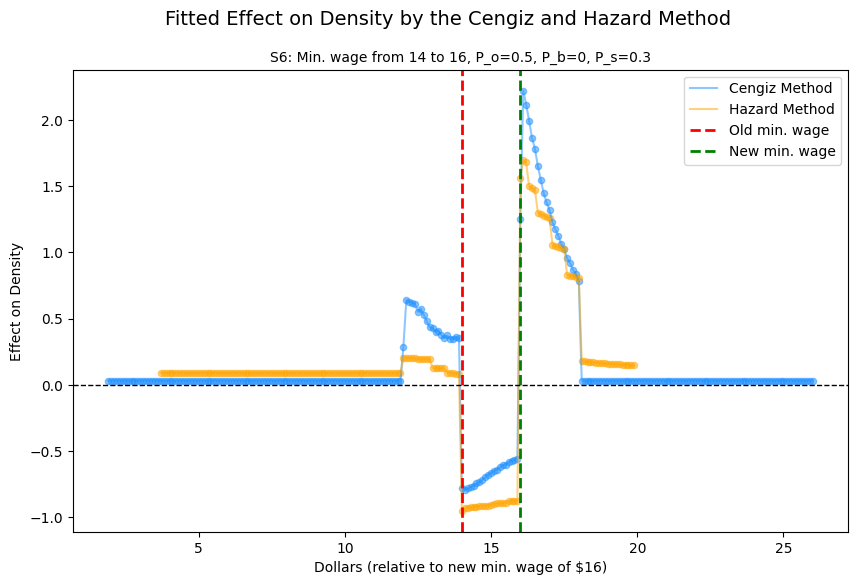

In [112]:
# Example usage with scenario and hazard method data
scenario_name = "S6"
scenario = scenarios[scenario_name]
print(scenario)

# Fit the Cengiz method
df_cengiz = fit_cengiz_density(log_wages, scenario, scenario_name)
# Fit the Hazard method
df_hazard = fit_hazard_density(scenario, scenario_name)

# Plot the combined effect on density for both methods
plot_effect_on_density(df_cengiz, df_hazard, scenario, scenario_name)


## Part III Proportional Exponential Spillover Method

Goal: simulate a spillover effect that has the exponential shape, with weights given from the wage density at each points.

Proposed method:
1. draw a sample from log exponential distribution
2. calculate kde density from the log_wages.
3. for each point drawn from the exponential distribution, calculate the weights from kde of log_wages.
4. resampling raw_samples with the weights 


The below figures show the distribution of proportional exponential spillovers under different scale. Our current spillover effect use scale = 0.1; however, with this scale, the weights won't matter that much. Even with higher scale such as 0.5, the location effect is not huge for non-extreme cases (m = 10, 14, or 20.) If we want to amplify the role of location, we might need to consider alternative distribution for spillover, or leverage the proportion (e.g., give 2.4x larger weight for 1.2x larger density)

In [ ]:
# same parameters as A but later we'll give spillover = "proportional_exponential"
B_scenarios = {
    'B1': (4, 6, 0.5, 0, 0.3),
    'B2': (8, 10, 0.5, 0, 0.3),
    'B3': (12, 14, 0.5, 0, 0.3),
    'B4': (16, 18, 0.5, 0, 0.3),
}

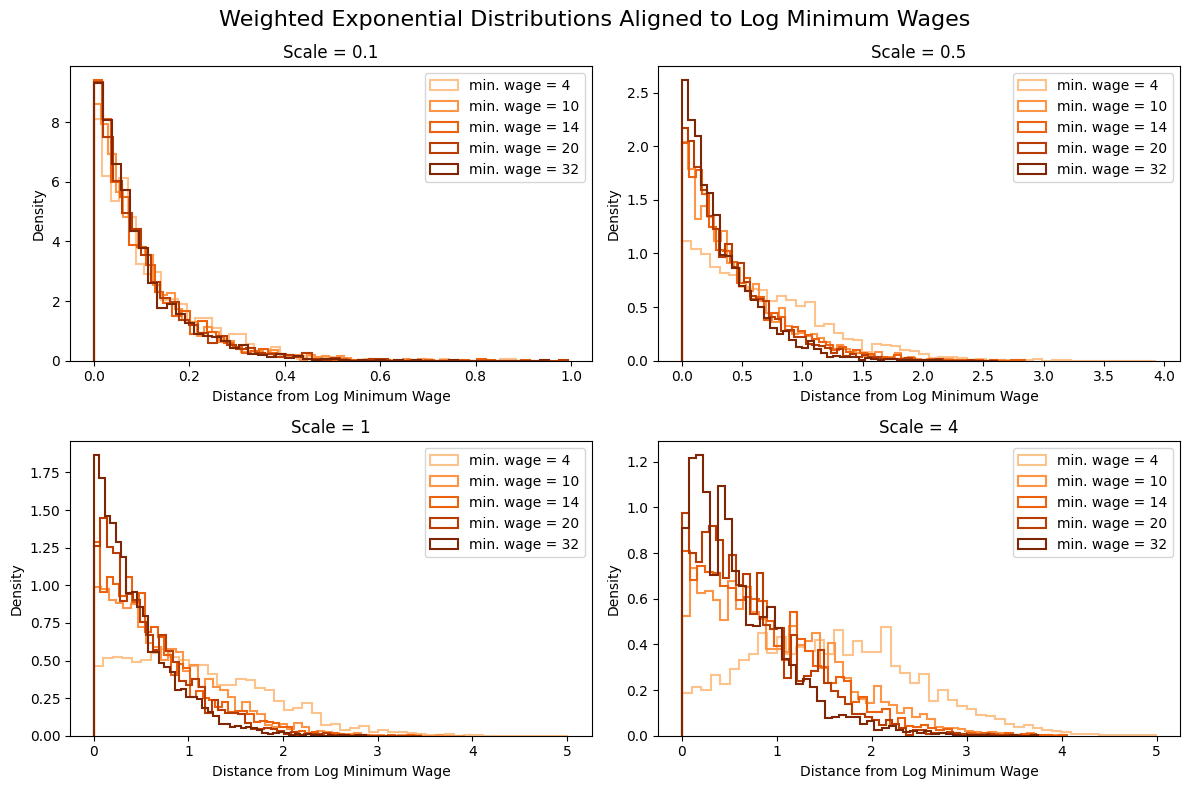

In [27]:
def visualize_weighted_exponential_distributions(log_wages, real_m_values):
    colors = ['b', 'g', 'r', 'c']  # Different colors for each histogram
    # Define different scales for the exponential distribution
    scales = [0.1, 0.5, 1, 4]
    # Define the colormap and select colors starting from a darker shade
    cmap = sns.color_palette("Oranges", as_cmap=True)
    colors = [cmap(i) for i in np.linspace(0.3, 1, len(real_m_values))]

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()
    
    for idx, scale in enumerate(scales):
        ax = axes[idx]  # Select the appropriate subplot

        for i, real_m in enumerate(real_m_values):
            # Generate weighted exponential samples
            resampled_with_weights = generate_weighted_exponential_samples(log_wages.copy(), real_m, 10_000, scale)
            
            # Align by subtracting the minimum wage (log_m)
            log_m = np.log(real_m)
            aligned_resampled_with_weights = resampled_with_weights - log_m

            # Overlay the aligned weighted exponential distribution with hollow bars
            ax.hist(aligned_resampled_with_weights, bins=50, density=True, 
                    histtype='step', edgecolor=colors[i], linewidth=1.5, label=f'min. wage = {real_m}')

        ax.set_title(f'Scale = {scale}')
        ax.set_xlabel('Distance from Log Minimum Wage')
        ax.set_ylabel('Density')
        ax.legend()

    plt.suptitle('Weighted Exponential Distributions Aligned to Log Minimum Wages', fontsize=16)
    plt.tight_layout()
    plt.show()

# Define the real minimum wages and the corresponding log ranges
real_m_values = [4, 10, 14, 20, 32]
small_samples = generate_log_wages(10_000)
# Visualize the weighted exponential distributions
visualize_weighted_exponential_distributions(small_samples, real_m_values)


The below two figures show the result. When m = 4, the spillover effect of proportional exponential method is flat, as the density near minimum wage is much lower than going above; when we move above to m = 14 or even 20, the density of proportional exponential spillovers are more concentrated near the minimum wage. In all cases, spillover density near the minimum wage remain the highest.

We also see that setting scale to 0.5 gives a spillover that goes too high above the minimum wage; however, the two spillover still make little difference.

In [28]:
def compare_spillover_methods_across_minimum_wages(log_w, real_m_values, P_o, P_b, P_s, spillover_scale=0.1):
    # Prepare a 2x2 grid for the figures
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()
    
    for idx, real_m in enumerate(real_m_values):
        ax = axes[idx]  # Select the appropriate subplot
        
        # Run the impose_minimum_wage function for both spillover methods
        df_exponential = impose_minimum_wage(log_w.copy(), real_m, P_o, P_b, P_s, spillover="exponential", spillover_scale=spillover_scale)
        df_proportional_exponential = impose_minimum_wage(log_w.copy(), real_m, P_o, P_b, P_s, spillover="proportional_exponential", spillover_scale=spillover_scale)
        
        # Generate the no minimum wage effect distribution
        df_no_minimum_wage = impose_minimum_wage(log_w.copy(), real_m, P_o=0, P_b=0, P_s=0)
        
        # Calculate the number of bins such that the minimum wage is on the edge
        bin_edges = np.linspace(min(log_w.copy()), max(log_w.copy()), 101)  # 100 bins
        
        # No minimum wage effect
        ax.hist(df_no_minimum_wage['adjusted_log_wages'].dropna(), bins=bin_edges, density=True, 
                color='orange', alpha=0.2, label='No Minimum Wage Effect')
        
        # Exponential spillover
        ax.hist(df_exponential['adjusted_log_wages'].dropna(), bins=bin_edges, density=True, 
                histtype='step', edgecolor='blue', linewidth=1.5, alpha=0.7, label='Exponential Spillover')
        
        # Proportional exponential spillover
        ax.hist(df_proportional_exponential['adjusted_log_wages'].dropna(), bins=bin_edges, density=True, 
                histtype='step', edgecolor='green', linewidth=1.5, alpha=0.7, label='Proportional Exponential Spillover')
        
        # Add a vertical line at the log of the minimum wage
        log_m = np.log(real_m)
        ax.axvline(log_m, color='red', linestyle='--', linewidth=2, label='Minimum Wage')
        
        ax.set_title(f'Minimum Wage = {real_m}')
        ax.set_xlabel('Log Wages')
        ax.set_ylabel('Density')

    # Add a title for the entire figure
    fig.suptitle(f'Comparison Between Two Spillover Methods Across Minimum Wage (Scale = {spillover_scale})', fontsize=16)

    # Move the legend to the bottom of the figure
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', fontsize=12, ncol=4)

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Adjust layout to make room for the legend
    plt.show()

# Generate log wages data
log_wages_test = generate_log_wages(10_000)

# Compare the distributions for different minimum wages
real_m_values = [4, 10, 14, 20]


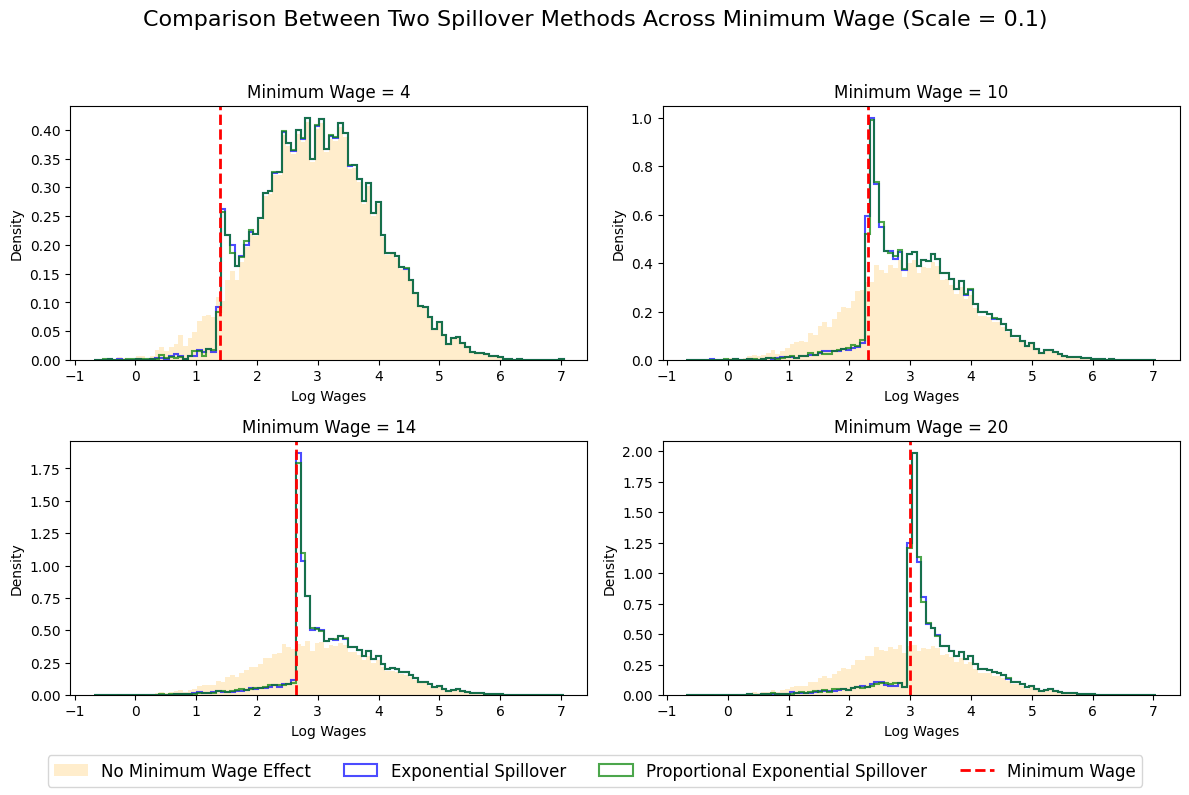

In [29]:
compare_spillover_methods_across_minimum_wages(log_wages_test, real_m_values, P_o=0.3, P_b=0, P_s=0.5)

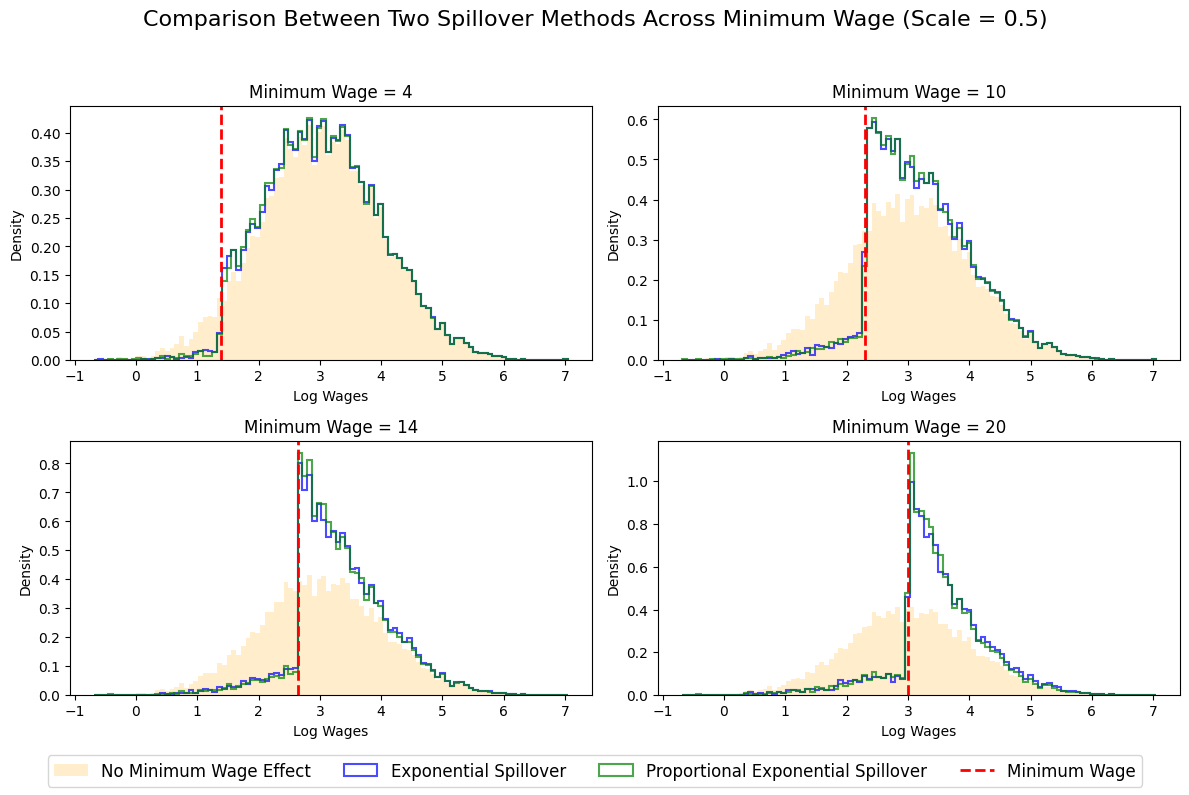

In [30]:
compare_spillover_methods_across_minimum_wages(log_wages_test, real_m_values, P_o=0.3, P_b=0, P_s=0.5, spillover_scale=0.5)

#### Replicating Part II for proportional exponential method

For this part, I set scale to be 0.1. We barely see any difference between these figures and the one in previous section (using exponential spillovers)


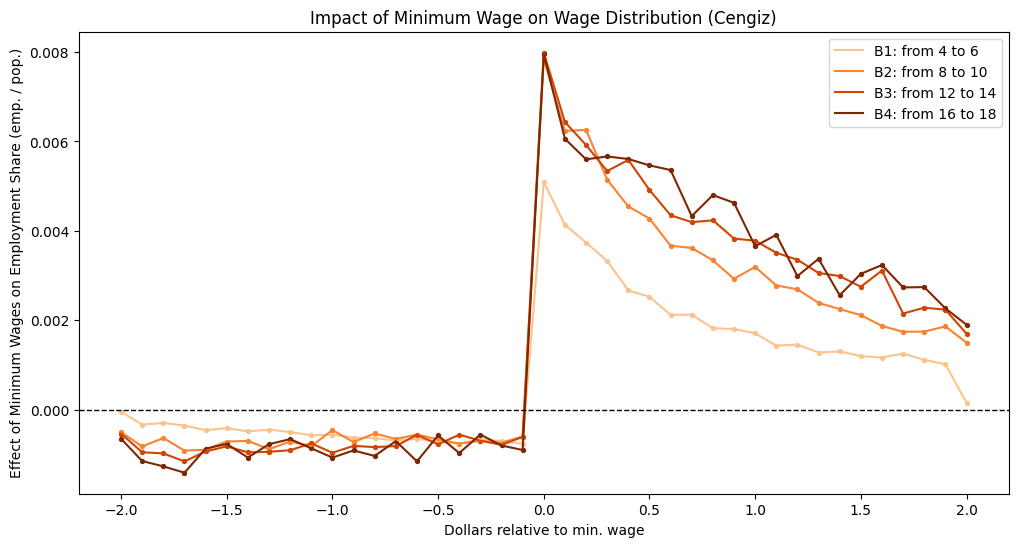

In [ ]:
# Example call to the function
plot_cengiz_fe_overlay(log_wages, B_scenarios, spillover = "proportional_exponential")

In [47]:
# loop through the scenarios
for scenario, params in B_scenarios.items():
    real_m_pre, real_m_post, P_o, P_b, P_s = params
    df_grouped = prepare_hazard_var(log_wages, real_m_pre, real_m_post, P_o, P_b, P_s, spillover="proportional_exponential")
    df_grouped['Scenario'] = scenario
    print(f"Scenario: {scenario}")
    df_grouped.to_stata(f'data/df_grouped_{scenario}.dta')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Scenario: B1


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Scenario: B2


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Scenario: B3
Scenario: B4


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [48]:
%%stata
# execute the following do.file
do "codes/hazard simulation.do" "B1 B2 B3 B4"


. # execute the following do.file
Unknown #command
. do "codes/hazard simulation.do" "B1 B2 B3 B4"

. cd "/Users/boyuchen/Documents/UBC/RA/minimum_wage"
/Users/boyuchen/Documents/UBC/RA/minimum_wage

. 
. local scenarios `1'

. 
. * Clear the existing Excel file or create a new one
. putexcel set tables/glm_coefficients.xlsx, replace
note: file will be replaced when the first putexcel command is issued.

. putexcel set tables/ols_coefficients.xlsx, replace
note: file will be replaced when the first putexcel command is issued.

. putexcel set tables/lpm_coefficients.xlsx, replace
note: file will be replaced when the first putexcel command is issued.

. 
. foreach s in `scenarios'{
  2. quietly{
  3.     
.         di "Run GLM for scenario `s'"
  4.         use data/df_grouped_`s'.dta, clear
  5.         drop min_bin rel_min_bin min_sum
  6.         
.         su wagcat
  7.         local maxbin = `r(max)'
  8.         
.         glm fweight min* bin* if remain>0 & wagcat ~= 0 & wagcat 

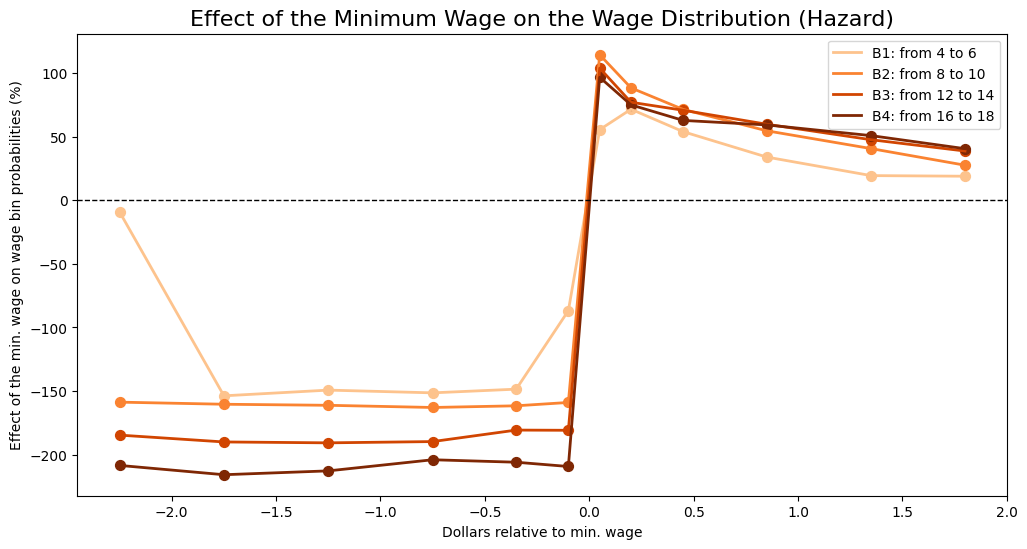

In [49]:
# Load the Excel file
file_path = 'tables/glm_coefficients.xlsx'

glm_result = pd.concat([format_data(file_path, scenario) for scenario in B_scenarios.keys() ])
# Filter the data for the variables of interest
glm_result = glm_result[glm_result['Variable'].isin(x_ranges.keys())]

# Example call to the function
plot_hazard_overlay(glm_result, B_scenarios)